### 2. Разведочный анализ данных (EDA), преобразование (Feature Engineering) и отбор признаков (Feature Selection).
_Он упал в огромное кожаное кресло, расстегнул пальто и закурил.  
– А ну-ка, займись, – сказал он. – Дано: запах селёдочного рассола, интенсивность шестнадцать микротопоров, кубатура… – Он оглядел комнату. – Ну, сам сообразишь, год на переломе, Сатурн в созвездии Весов… Удаляй!_

_Я почесал за ухом.  
– Сатурн… Что ты мне про Сатурн… А вектор магистатум какой?  
– Ну, брат, – сказал Ойра-Ойра, – это ты сам должен…_

_Я почесал за другим ухом, прикинул в уме вектор и произвёл, запинаясь, акустическое воздействие (произнёс заклинание). Ойра-Ойра зажал нос. Я выдрал из брови два волоска (ужасно больно и глупо) и поляризовал вектор. Запах опять усилился.  
– Плохо, – с упрёком сказал Ойра-Ойра. – Что ты делаешь, ученик чародея? Ты что, не видишь, что форточка открыта?  
– А, – сказал я, – верно.  
Я учёл дивергенцию и ротор, попытался решить уравнение Стокса в уме, запутался, вырвал, дыша через рот, ещё два волоска, принюхался, пробормотал заклинание Ауэрса..._


In [1]:
import pandas as pd
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, RobustScaler
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, f1_score, recall_score, matthews_corrcoef
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve
from sklearn.utils import shuffle, resample

from scipy.stats import kurtosis, skew
import warnings

warnings.filterwarnings('ignore')

### Пользовательские функции и установки.

In [2]:
#------------------------------------------------------------------------------#
SEED = 42
#------------------------------------------------------------------------------#
# Изменение установок по умолчанию для графиков:
def set_rc_params():
    plt.rcParams.update({
        "axes.facecolor"       : "LightYellow",
        "axes.labelsize"       : 14,
        "axes.titlesize"       : 16,
        "axes.grid"            : True,
        "axes.grid.axis"       : "both",
        "grid.linestyle"       : "dotted",
        "grid.alpha"           : 0.75,
        "legend.facecolor"     : "Lavender",
        "legend.shadow"        : True,
        "legend.fontsize"      : 12,
        "legend.edgecolor"     : "black",
        "legend.title_fontsize": 11,
        "figure.facecolor"     : "Lavender",
        "xtick.labelsize"      : 12,
        "ytick.labelsize"      : 12,
        "font.size"            : 16
    })

# Восстановление установок графиков по умолчанию:
def set_rc_default():
    plt.rcdefaults()

#------------------------------------------------------------------------------#
# Переопределяем графические настройки:
set_rc_params()

#------------------------------------------------------------------------------#
def confusion_table_and_ROC(model, X_test, y_test, y_predict):
    """
    Строит матрицу ошибок в привычном для меня формате:
        * в строках - предсказания модели.
        * в столбцах - фактические классы.
        * левый верхний = TP.
    Также строит график для ROC.
    
    На входе:
        * y_test - фактические классы тестового вектора.
        * y_predict - классы, предсказанные моделью.
            
    На выходе:
        * графическая форма матрицы ошибок.
        * ROC.
    """
    conf_tab = confusion_matrix(y_test, y_predict)
    a = conf_tab.copy()
# Преобразуем матрицу ошибок к привычному мне виду:
    a[0,0] = conf_tab[1,1]
    a[1,1] = conf_tab[0,0]
    a[0,1] = conf_tab[0,1]
    a[1,0] = conf_tab[1,0]
# График:    
    fig, ax = plt.subplots(1,2, figsize=(17,7)); fig.subplots_adjust(wspace=0.1)
    annot_kws = {'fontsize': 20}
    group_names = ['TP', 'FP', 'FN', 'TN']
    group_counts = ['{0:_.0f}'.format(value) for value in a.flatten()]
    labels = [f'{v1}\n\n{v2}' for v1, v2 in zip(group_names, group_counts)]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(a, annot=labels, fmt='', cmap='Spectral_r', vmin=0, vmax=0,
                cbar=False, linewidths=.5, annot_kws=annot_kws, ax=ax[0])
# Текстовая обвязка:
    ax[0].set_xticklabels(['Дефолт\nPositive', 'Не-дефолт\nNegative'], size=14)
    ax[0].set_yticklabels(['Дефолт\nPositive', 'Не-дефолт\nNegative'], rotation=0,
                          size=14)
    ax[0].set_xlabel('Фактически', size=18)
    ax[0].set_ylabel('Модель', rotation=0, ha="left", va="center_baseline",
                  size=18)
    ax[0].set_title('Матрица ошибок', style='italic', size=20);
# ROC:    
    plot_roc_curve(model, X_test, y_test, ax=ax[1], color='blue', linewidth=2)
    plt.plot([0,1], [0,1], label='Случайное угадывание (AUC = 0.5)',
             color='red', ls='--')
    ax[1].set_xlabel('FPR')
    ax[1].set_ylabel('TPR', rotation=0, position=(0, 1.01), ha='left')
    ax[1].legend(loc="lower right"); ax[1].set_title('ROC', style='italic',
                                                     size=20);
#------------------------------------------------------------------------------#

def confusion_table_ROC_and_PRC(model, X_test, y_test, y_predict):
    """
    Строит матрицу ошибок в привычном для меня формате:
        * в строках - предсказания модели.
        * в столбцах - фактические классы.
        * левый верхний = TP.
    Также строит графики для ROC и для Precision-Recall.
    
    На входе:
        * y_test - фактические классы тестового вектора.
        * y_predict - классы, предсказанные моделью.
            
    На выходе:
        * графическая форма матрицы ошибок.
        * ROC.
        * Precision-Recall curve.
    """
    conf_tab = confusion_matrix(y_test, y_predict)
    a = conf_tab.copy()
# Преобразуем матрицу ошибок к привычному мне виду:
    a[0,0] = conf_tab[1,1]
    a[1,1] = conf_tab[0,0]
    a[0,1] = conf_tab[0,1]
    a[1,0] = conf_tab[1,0]
# Матрица ошибок:    
    fig, ax = plt.subplots(1,3, figsize=(18,4)); fig.subplots_adjust(wspace=0.1)
    annot_kws = {'fontsize': 20}
    group_names = ['TP', 'FP', 'FN', 'TN']
    group_counts = ['{0:_.0f}'.format(value) for value in a.flatten()]
    labels = [f'{v1}\n\n{v2}' for v1, v2 in zip(group_names, group_counts)]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(a, annot=labels, fmt='', cmap='Spectral_r', vmin=0, vmax=0,
                cbar=False, linewidths=.5, annot_kws=annot_kws, ax=ax[0])
#---
    ax[0].set_xticklabels(['Дефолт\nPositive', 'Не-дефолт\nNegative'], size=14)
    ax[0].set_yticklabels(['Дефолт\nPositive', 'Не-дефолт\nNegative'], rotation=0,
                          size=14)
    ax[0].set_xlabel('Фактически', size=16, fontweight='bold')
    ax[0].set_ylabel('Модель', rotation=0, ha="left", va="center_baseline",
                  size=16, fontweight='bold')
    ax[0].set_title('Матрица ошибок', style='italic', size=18);
# ROC:    
    plot_roc_curve(model, X_test, y_test, ax=ax[1], color='blue',
                   linewidth=2, name='LogReg')
    sns.lineplot(x=[0,1], y=[0,1], label='Гадалка (AUC = 0.50)',
             color='red', ls='--', ax=ax[1])
#---
    ax[1].set_xlabel('FPR')
    ax[1].set_ylabel('TPR', rotation=0, position=(0, 1.01), ha='left')
    ax[1].legend(loc="lower right"); ax[1].set_title('ROC', style='italic',
                                                     size=18);
# Precision-Recall curve:
    plot_precision_recall_curve(model, X_test, y_test, linewidth=2, ax=ax[2],
                            color='MediumSlateBlue', name='LogReg');
    ratio_P = y_test.value_counts()[1] / y_test.shape[0]
    sns.lineplot(x=[0,1], y=[ratio_P,ratio_P], color='red', ls='--', ax=ax[2],
                 label=f'Гадалка (AP = {ratio_P:.2f})')
    ax[2].set_xlabel('Recall')
    ax[2].set_ylabel('Precision', rotation=0, position=(0, 1.01), ha='left')
    ax[2].legend(loc="upper right"); ax[2].set_title('PRC', style='italic',
                                                     size=18);
#------------------------------------------------------------------------------#
def feature_importance_on_log_reg_coef(coef_log_reg, feature_list, f_count=100):
    """
    """
    df_coef = pd.DataFrame(coef_log_reg, index=feature_list, columns=['coeffs'])
# Ранжирование признаков по модулю весовых коэффициентов:
    if f_count == 100:
        ds_rank = df_coef.coeffs.apply(abs).nlargest(df_coef.shape[0])
    else:
        ds_rank = df_coef.coeffs.apply(abs).nlargest(f_count)
#---
    fig, ax = plt.subplots(1, 2, figsize=(22,5)); fig.subplots_adjust(wspace=0.1)
# Цветовая карта:
    if f_count == 100:
        x_val = df_coef.coeffs.values; x_val = abs(x_val)
        t_val = (x_val - x_val.min())/(x_val.max() - x_val.min())
        colors = plt.get_cmap('autumn_r')(t_val)
        sns.barplot(x=df_coef.index, y=df_coef.coeffs, palette=colors,
                    ax=ax[1])
    else:
        x_val = df_coef.coeffs.values[:f_count]; x_val = abs(x_val)
        t_val = (x_val - x_val.min())/(x_val.max() - x_val.min())
        colors = plt.get_cmap('autumn_r')(t_val)
        sns.barplot(x=df_coef.index[:f_count], y=df_coef.coeffs.values[:f_count],
                    palette=colors, ax=ax[1])
# Цветовая карта:
    x_val = ds_rank.values; x_val = abs(x_val)
    t_val = (x_val - x_val.min())/(x_val.max() - x_val.min())
    colors = plt.get_cmap('autumn_r')(t_val)
    sns.barplot(x=ds_rank.index, y=ds_rank.values, palette=colors, ax=ax[0])
#---
    plt.setp(ax[1].get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    plt.setp(ax[0].get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    ax[1].set_ylabel(''); 
    [axx.grid('both') for axx in ax]
    ax[1].set_title('Весовые коэффициенты логистической регрессии',
                    style='italic')
    ax[0].set_title('Рейтинг значимости признаков', style='italic');
#------------------------------------------------------------------------------#

def get_graphs_for_binning(df, col, bins=10, strategy='quantile'):
    """
    """
    fig, ax = plt.subplots(1, 2, figsize=(18, 4))
    fig.subplots_adjust(wspace=0.11)
# Было:
    if df[col].nunique() < 150:
        sns.histplot(data=df, x=col, discrete=True, ax=ax[0], hue='default',
                 palette=['g', 'r'], multiple="stack", edgecolor='lightyellow')
    else:
        sns.histplot(data=df, x=col, bins=150, ax=ax[0], hue='default',
                 palette=['g', 'r'], multiple="stack", edgecolor='lightyellow')
    ax[0].set_title(f'Признак {col}: ДО биннинга', style='italic'); 
    ax[0].set_ylabel('Count', rotation=0, position=(0,1.01), ha='left')
#---
    qbin = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy=strategy)
    df[col] = qbin.fit_transform(df[col].values.reshape(-1,1))
    edges_lst = [int(k) for k in qbin.bin_edges_[0]]
# Стало:
    sns.histplot(data=df, x=col, discrete=True, ax=ax[1], hue='default', 
                 palette=['g', 'r'], multiple="stack", legend=False,
                 edgecolor='lightyellow')
    ax[1].set_title(f'Признак {col}: ПОСЛЕ биннинга', style='italic');
    ax[1].set_xticks(range(bins))
    ax[1].set_xlabel(f'Категории признака {col}')
    ax[1].set_ylim(0, df[col].value_counts().max()+1000);
    ax[1].set_ylabel('')
    class_P = df[df.default==1][col].value_counts().sort_index()
    class_N = df[df.default==0][col].value_counts().sort_index()
    for k, (valP, valN) in enumerate(zip(class_P, class_N)):
        ax[1].text(x=k, y=valP, s=f'{valP}', ha='center', va='bottom',
                   color='r', fontsize=10)
        ax[1].text(x=k, y=valN, s=f'{valN}', ha='center', va='center',
                   color='w', fontsize=10)
        ax[1].text(x=k, y=valN+valP, s=f'{valN+valP}', ha='center', va='bottom',
                   color='k', fontsize=10)
#---
    df[col] = df[col].apply(int)
    df_cat = pd.DataFrame(df[df.default==1][col].value_counts().sort_index())
    df_cat = df_cat.join(
             pd.DataFrame(df[df.default==0][col].value_counts().sort_index()), 
             lsuffix='_P', rsuffix='_N')
    df_cat = df_cat.join(
            pd.DataFrame(df[col].value_counts().sort_index()))
    df_cat = df_cat.rename_axis('category $\longrightarrow$', axis=0).rename_axis(
                            f'$\downarrow$ {col}: count', axis=1).T
#---
    return df_cat
#------------------------------------------------------------------------------#
#------------------------------------------------------------------------------#
def get_WoE_and_IV(df, col, cat_lst):
    """
    """
    df_ = pd.DataFrame
    qbin = np.quantile(df[col], cat_lst)
# Класс "Дефолт":
    hh = np.histogram(df[df.default==1][col], bins=qbin)
    df_cat = df_(hh[0], columns=[f'{col}_P'])
# Класс "Не-Дефолт":
    hh = np.histogram(df[df.default==0][col], bins=qbin)
    df_cat = df_cat.join(df_(hh[0], columns=[f'{col}_N']))
# Сумма классов:
    hh = np.histogram(df[col], bins=qbin)
    df_cat = df_cat.join(df_(hh[0], columns=[col]))
# Вероятности (относительные частоты) класса "Дефолт":
    proba_P = df_cat[f'{col}_P'] / df_cat[f'{col}_P'].sum()
# Вероятности (относительные частоты) класса "Не-Дефолт":
    proba_N = df_cat[f'{col}_N'] / df_cat[f'{col}_N'].sum()
# Вычисляем WoE:
    WoE = np.log(proba_P/proba_N)
# Записываем WoE в таблицу:
    df_cat = df_cat.join(df_(WoE, columns=['WoE']))
#---
    df_cat = df_cat.T
# IV (Information value) - значимость признака:
    InfValue = (proba_P - proba_N) * WoE
    print(f'Information Value for feature "{col}": {InfValue.sum():.0e}')
#---
    plt.plot(WoE.index, WoE.values, lw=1, color='b', marker='o', markersize=10)
    fig, ax = plt.gcf(), plt.gca(); fig.set_size_inches(10,4)
    xmin = ax.get_xlim()[0]; xmax = ax.get_xlim()[1]
    ax.set_xticks(range(df_cat.shape[1])); ax.set_xlim(xmin, xmax)
    ax.set_ylabel('WoE', rotation=0, position=(0.,1.02), fontsize=16, ha='left')
    ax.set_xlabel(f'Категории признака {col}')
    ax.set_title(f'Распределение WoE по категориям признака {col}',
                 style='italic');
    plt.plot([-1e7, 1e7], [0, 0], lw=2, c='k', ls='--') # Линия нуля.
#---
    df_IV = df_(InfValue.sum(), columns=[col], index=['IV']) # IV для col
    cat_dict = {col: list(hh[1])} # Словарь "признак": [квантили]
    return df_cat, df_IV, cat_dict
#------------------------------------------------------------------------------#
#------------------------------------------------------------------------------#
def get_WoE_and_IV_for_categoric_feature(df, col):
    """
    """
    df_ = pd.DataFrame
# Класс "Дефолт":
    class_P = df[df.default==1][col].value_counts().sort_index()
    df_P = df_(class_P); df_P.columns = ['count_class_P']
# Класс "Не-Дефолт":
    class_N = df[df.default==0][col].value_counts().sort_index()
    df_N = df_(class_N); df_N.columns = ['count_class_N']
# Сумма классов:
    df_PN = df_(class_P + class_N); df_PN.columns = ['count_total']
# Вероятности (относительные частоты) класса "Дефолт":
    sum_class_P = class_P.sum()
    proba_P = class_P / sum_class_P
# Вероятности (относительные частоты) класса "Не-Дефолт":
    sum_class_N = class_N.sum()
    proba_N = class_N / sum_class_N
# Вычисляем WoE:
    WoE = np.log(proba_P/proba_N)
    df_WoE = df_(WoE); df_WoE.columns = ['WoE']
# Записываем WoE в таблицу:
    df_cat = df_P.join(df_N).join(df_PN).join(df_WoE)
    df_cat = df_cat.T.rename_axis(f'{col}', axis=1)
#---
# IV (Information value) - значимость признака:
    InfValue = (proba_P - proba_N) * WoE
#---
    plt.plot(WoE.index, WoE.values, lw=1, color='b', marker='o', markersize=10)
    fig, ax = plt.gcf(), plt.gca(); fig.set_size_inches(10,4)
    xmin = ax.get_xlim()[0]; xmax = ax.get_xlim()[1]
    ax.set_xticks(range(df_cat.shape[1])); ax.set_xlim(xmin, xmax)
    ax.set_ylabel('WoE', rotation=0, position=(0.,1.02), fontsize=16, ha='left')
    ax.set_xlabel(f'Категории признака {col}')
    ax.set_title(f'Распределение WoE по категориям признака {col}',
                 style='italic');
    plt.plot([-1e7, 1e7], [0, 0], lw=2, c='k', ls='--') # Линия нуля.
#---
    df_IV = df_(InfValue.sum(), columns=[col], index=['IV']) # IV для col
    cat_dict = {col: df_cat.columns.to_list()} # Словарь "признак": [категории]
    return df_cat, df_IV, cat_dict
#------------------------------------------------------------------------------#
#------------------------------------------------------------------------------#
def transform_to_WoE_values(x, num = True):
    """
    Локальная функция для преобразования значений признака в значения его WoE.
    На входе:
        - текущее значение признака
        - "флаг" типа признака: числовой или категориальный
    На выходе:
        - соответствующее значение WoE
    """
    if num:
# Последняя категория - включаем равенство на ОБЕИХ границах:
        if x >= edges_list[-2] and x <= edges_list[-1]: return WoE_list[-1]
#---    
        for k in range(len(edges_list) - 1):
            if x >= edges_list[k] and x < edges_list[k + 1]:
                return WoE_list[k]
    return WoE_list[edges_list.index(x)]
#------------------------------------------------------------------------------#
#------------------------------------------------------------------------------#
def delta(asc=False):
    """
    Локальная функция проверки преобразования признака в его WoE-значения.
    На входе:
        - булев параметр характера распределения WoE по категориям признака.
          По умолчанию распределение WoE считается убывающим.
    На выходе:
        - таблица разности величин. Должна состоять из нулей.
    """
    df_ = pd.DataFrame
    df = data_LR[data_LR.flag=='train'][[col, 'default']].copy()
    class_P = df[df.default==1][col].value_counts().sort_index(ascending=asc)
    class_N = df[df.default==0][col].value_counts().sort_index(ascending=asc)
    df = df_(df[col].value_counts().sort_index(ascending=asc))
    df = df.reset_index().rename(columns={'index': 'WoE'})
    df = df.join(df_(class_P.values, columns=[f'{col}_P']))
    df = df.join(df_(class_N.values, columns=[f'{col}_N']))
    cols = [f'{col}_P', f'{col}_N', col, 'WoE']
# Должен дать таблицу с нулями:
    return df[cols] - df_cat.T[cols]
#------------------------------------------------------------------------------#
#------------------------------------------------------------------------------#
def get_nbins_for_minimal_std(n_min, n_max):
    """
    Локальная функция, отыскивает оптимальное количество интервалов разбиения.
    Найденное количество интервалов соответствует минимальному разбросу.
    На входе:
        - минимальное и максимальное количество разбиений.
    На выходе:
        - минимальная величина разброса и соответствующее количество разбиений.
    """
    min_val = 1e10
    for n_bins in range(n_min, n_max + 1):
        dff = df[[col]].copy()
        qbin = KBinsDiscretizer(n_bins=n_bins, encode='ordinal',
                                strategy='quantile')
        dff[col] = qbin.fit_transform(dff[col].values.reshape(-1,1))
        arr = dff[col].value_counts().values
        mean_val, std_val = np.mean(arr), np.std(arr)
        std_rel = std_val / mean_val * 100
        if std_rel <= min_val:
            min_val = std_rel
            bins = n_bins
    return min_val, bins
#------------------------------------------------------------------------------#
#------------------------------------------------------------------------------#
def transform_to_cat(x):
    """
    
    """
# Последняя категория - включаем равенство на ОБЕИХ границах:
    if x >= edges_list[-2] and x <= edges_list[-1]: return len(cat_list) - 1
#---    
    for k in range(len(edges_list) - 1):
        if x >= edges_list[k] and x < edges_list[k + 1]:
            return k
#------------------------------------------------------------------------------#
#------------------------------------------------------------------------------#

In [3]:
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')
# Добавляем идентификатор:
data_train['flag'] = 'train'
data_test['flag'] = 'test'
# В таблице 'test' нет целевого признака.
# Добавим его с заведомо неправильным значением:
data_test['default'] = -100
# Склеиваем:
data = pd.concat([data_train, data_test], ignore_index=True)
data[:5]

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,flag
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0,train
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0,train
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0,train
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0,train
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0,train


In [4]:
data_root = data.copy()

* `client_id` - идентификатор клиента
* `education` - уровень образования
* `sex` - пол заёмщика
* `age` - возраст заёмщика
* `car` - флаг наличия автомобиля
* `car_type` - флаг автомобиля иномарки
* `decline_app_cnt` - количество отказанных прошлых заявок
* `good_work` - флаг наличия “хорошей” работы
* `bki_request_cnt` - количество запросов в БКИ
* `home_address` - категоризатор домашнего адреса
* `work_address` - категоризатор рабочего адреса
* `income` - доход заемщика
* `foreign_passport` - наличие загранпаспорта
* `sna` - связь заемщика с клиентами банка
* `first_time` - давность наличия информации о заемщике
* `score_bki` - скоринговый балл по данным из БКИ
* `region_rating` - рейтинг региона
* `app_date` - дата подачи заявки
* `default` - флаг дефолта по кредиту

In [5]:
# Числовые признаки:
num_cols = ['age', 'decline_app_cnt', 'income', 'bki_request_cnt', 'score_bki']
# Категориальные бинарные признаки:
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work']
# Категориальные небинарные признаки:
cat_cols = ['education', 'home_address', 'work_address', 'sna', 'first_time', 'region_rating']
# Признаки даты:
date_cols = ['app_date']

In [6]:
# Пропуски:
data.isnull().sum()

client_id             0
app_date              0
education           478
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
flag                  0
dtype: int64

#### Прежде чем создавать базовую модель, необходимо заполнить пропуски в признаке `education` и преообразовать нечисловые признаки - в числовые.

#### 2.1. Обработка пропусков и преобразование категорий в числа для признака **education**.
В наличии 478 пропусков.

Существуют разные способы обработки пропусков. Самый простой - удаление строк с пропусками. Если же данный способ отвергается, то можно заполнить пропуски наиболее частым значением или средней (медианной) величиной. Ещё одна возможность - использовать модель МО для предсказания значений для пропущенных данных.

Мы используем простой вероятностый подход, основанный на априорных "частотных" вероятностях категорий признака `education`.

In [7]:
#------------------------------------------------------------------------------#
# Вычисляем таблицу априорных вероятностей категорий признака education:
df_probs = pd.DataFrame(data.education.value_counts(normalize=True)).rename(
                        columns={'education': 'probs'})
display(df_probs)

,probs
SCH,0.528841
GRD,0.317024
UGR,0.134476
PGR,0.017006
ACD,0.002653


In [8]:
#------------------------------------------------------------------------------#
# Заполняем пропуски с использованием вычисленного распределения вероятностей:
df = data.copy()
np.random.seed(1)
for k in data[data.education.isnull()].index:
    data.loc[k, 'education'] = np.random.choice(df_probs.index, size=1,
        p=df_probs.probs.values)[0]
#---
df_pre_post = pd.DataFrame(df['education'].value_counts()).join(
              pd.DataFrame(data['education'].value_counts()),
              lsuffix='_pre', rsuffix='_post')
df_pre_post['delta'] = df_pre_post.education_post - df_pre_post.education_pre
df_pre_post

,education_pre,education_post,delta
SCH,57998,58235,237
GRD,34768,34929,161
UGR,14748,14819,71
PGR,1865,1874,9
ACD,291,291,0


Таким образом, пропущенные значения были распределены между имеющимися категориями признака `education` в соответствии с априорными вероятностями этих категорий. Категории данного признака обладают отношением порядка, их можно упорядочить в смысле: 'SCH' - наиболее низкое образование, 'ACD' - самое выское образование. Преобразуем соответственно эти категории в числа.

In [9]:
#------------------------------------------------------------------------------#
# Словарь с уровнями образования по возрастанию уровней:
cat_order = {'SCH': 0, 'UGR': 1, 'GRD': 2, 'PGR': 3, 'ACD': 4}
data.education = data.education.replace(to_replace=cat_order)
data.education.value_counts().sort_index()

0    58235
1    14819
2    34929
3     1874
4      291
Name: education, dtype: int64

#### 2.2. Преобразование категорий в числа для признака **sex**.
Признак `sex` имеет номинальный тип, т.е. его категории не имеют отношения порядка. Однако данный признак (как и все бинарные признаки) можно смело преобразовывать в {0; 1}, избегая тем самым "dummy trap".

In [10]:
#------------------------------------------------------------------------------#
display(data.sex.value_counts())
cat_order = {'F': 0, 'M': 1}
data.sex = data.sex.replace(to_replace=cat_order)
data.sex.value_counts()

F    61836
M    48312
Name: sex, dtype: int64

0    61836
1    48312
Name: sex, dtype: int64

#### 2.3. Преобразование двух бинарных признаков **car** и **car_type** в один тринарный признак.
Эти бинарные признаки являются ординальными. Мы их скомбинируем в один признак с тремя категориями. Назовём его просто `car`.

In [11]:
#------------------------------------------------------------------------------#
cat_order = {'N': 0, 'Y': 1}
data.car = data.car.replace(to_replace=cat_order) + data.car_type.replace(
                                                    to_replace=cat_order)
# Удалаяем признак car_type:
data.drop(columns=['car_type'], inplace=True)
#---
data.car.value_counts().sort_index()

0    74290
1    14850
2    21008
Name: car, dtype: int64

#### 2.4. Преобразование бинарного признака **foreign_passport**.

In [12]:
#------------------------------------------------------------------------------#
display(data.foreign_passport.value_counts())
cat_order = {'N': 0, 'Y': 1}
data.foreign_passport = data.foreign_passport.replace(to_replace=cat_order)
data.foreign_passport.value_counts()

N    93721
Y    16427
Name: foreign_passport, dtype: int64

0    93721
1    16427
Name: foreign_passport, dtype: int64

#### 2.5. Обработка признака времени **app_date**.
Дата подачи заявки. Можно преобразовать этот признак в количество месяцев и дней, начиная с минимальной даты. Однако при таком подходе количество месяцев и количество дней будут, очевидно, сильно коррелировать друг с другом. Поэтому сделаем только количество дней.

In [13]:
#------------------------------------------------------------------------------#
data.app_date = pd.to_datetime(data.app_date) # Год-месяц-день
date_min = data.app_date.min()
data.app_date = (data.app_date - date_min).dt.days
data.app_date

0          31
1          70
2          31
3          22
4         107
         ... 
110143     89
110144    114
110145     88
110146      6
110147     75
Name: app_date, Length: 110148, dtype: int64

Минимальное количество дней: 0
Максимальное количество дней: 119


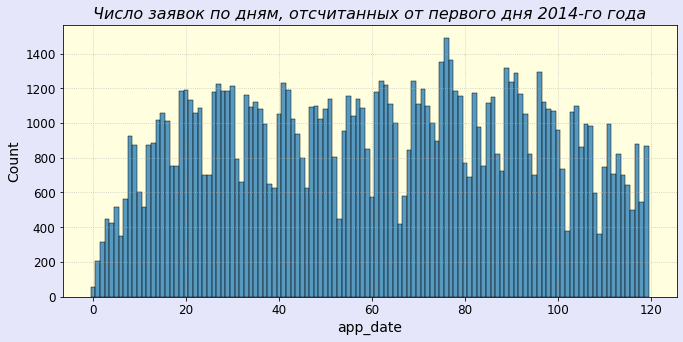

In [14]:
#------------------------------------------------------------------------------#
print('Минимальное количество дней:', data.app_date.min())
print('Максимальное количество дней:', data.app_date.max())
fig, ax = plt.subplots(figsize=(11, 5))
sns.histplot(data=data, x="app_date", discrete=True);
ax.set_title('Число заявок по дням, отсчитанных от первого дня 2014-го года',
                style='italic');

Данные в исходном датасете приведены за 120 дней 2014-го года, начиная с 1-го января. На графике хорошо видно, что пики идут группами по пять дней, т.е. локальные провалы соответствуют, по-видимому, выходным дням. В целом, число заявок по будням колеблется на уровне от 1000 до 1200 в день.

#### 2.6. Обработка признака **decline_app_cnt**.
Как мы видели в Разделе 1, этот признак имеет самое неравномерное распределение. Применять монотонное преобразование к нему бессмысленно - по сути, распределение этого признака является "половинчатым" (половина плотности распределения). В нуле сосредоточено около 83% клиентов. Правый хвост этого признака тянется в область редких значений, которые являются по сути аномалиями.

"Отрежем" редкие значения. В качестве "отсечки" используем процентиль 99%, и поместим редкие значения в отдельную категорию, номер которой на 1 больше процентиля 99%.

In [15]:
#------------------------------------------------------------------------------#
df = data.copy()
col = 'decline_app_cnt'
q_99 = np.percentile(data[col], 99.)
print(f'Процентиль 99% : {q_99}')
#---
data[col] = data[col].apply(lambda x: q_99 + 1 if x > q_99 else x).astype(int)
data[col].value_counts().sort_index()

Процентиль 99% : 4.0


0    91471
1    12500
2     3622
3     1365
4      606
5      584
Name: decline_app_cnt, dtype: int64

категории:,0,1,2,3,4,5
decline_app_cnt,91471,12500,3622,1365,606,584


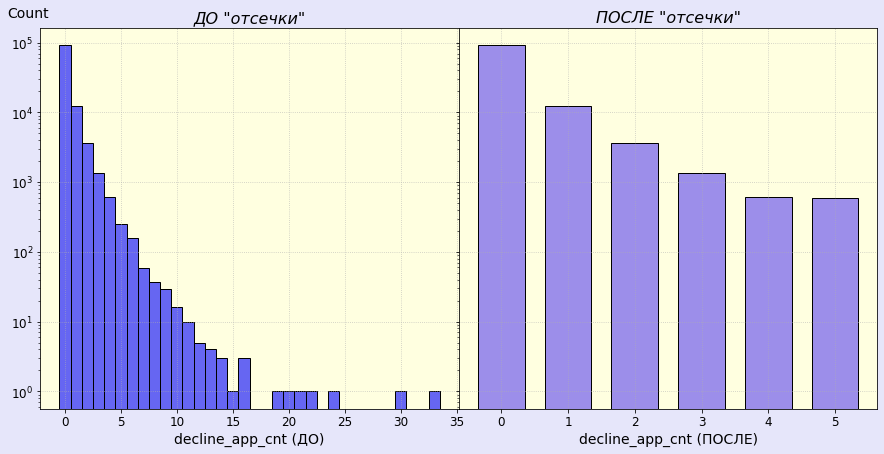

In [16]:
#------------------------------------------------------------------------------#
fig, ax = plt.subplots(1, 2, figsize=(15, 7), sharey=True)
fig.subplots_adjust(wspace=0.)
#---
sns.histplot(data=df, x=col, discrete=True, ax=ax[0], color='blue', alpha=0.6)
sns.histplot(data=data, x=col, discrete=True, shrink=0.7, ax=ax[1],
             color='MediumSlateBlue')
#---
ax[0].set_xlabel(f'{col} (ДО)'); ax[1].set_xlabel(f'{col} (ПОСЛЕ)')
ax[0].set_ylabel('Count', rotation=0, position=(0., 1.02), ha='left');
ax[0].set_title('ДО "отсечки"', fontstyle='italic')
ax[1].set_title('ПОСЛЕ "отсечки"', fontstyle='italic');
[axs.set_yscale('log') for axs in ax];
#---
df_ = pd.DataFrame
df_(data[col].value_counts().sort_index()).rename_axis('категории:').T

#### 2.7. Обработка признака **bki_request_cnt**.
Второй по степени неоднородности распределения признак после `decline_app_cnt`. Имеет очень длинный правый хвост с редкими значениями. Поступим так же, как с признаком `decline_app_cnt`.

In [17]:
#------------------------------------------------------------------------------#
df = data.copy()
col = 'bki_request_cnt'
q_99 = np.percentile(data[col], 99)
print(f'Процентиль 99% : {q_99}')
#---
data[col] = data[col].apply(lambda x: q_99 + 1 if x > q_99 else x).astype(int)
data[col].value_counts().sort_index()

Процентиль 99% : 10.0


0     28908
1     27295
2     20481
3     13670
4      8406
5      4960
6      2500
7      1292
8       735
9       459
10      350
11     1092
Name: bki_request_cnt, dtype: int64

категории:,0,1,2,3,4,5,6,7,8,9,10,11
bki_request_cnt,28908,27295,20481,13670,8406,4960,2500,1292,735,459,350,1092


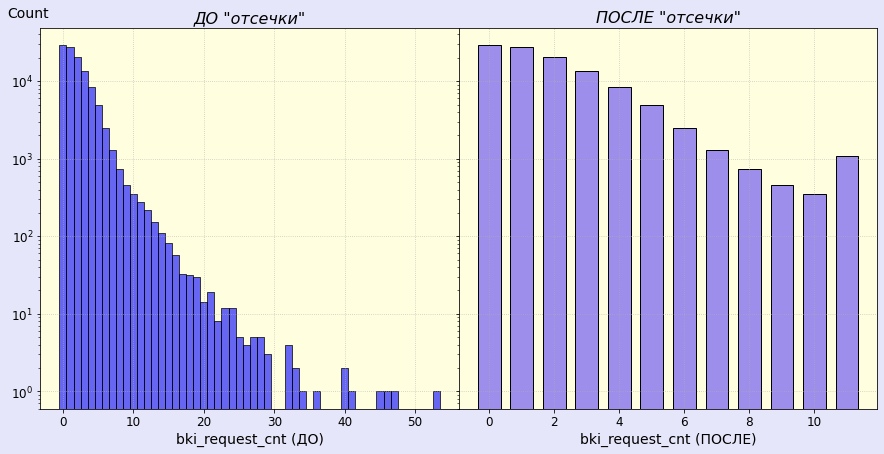

In [18]:
#------------------------------------------------------------------------------#
fig, ax = plt.subplots(1, 2, figsize=(15, 7), sharey=True)
fig.subplots_adjust(wspace=0.)
#---
sns.histplot(data=df, x=col, discrete=True, ax=ax[0], color='blue', alpha=0.6)
sns.histplot(data=data, x=col, discrete=True, shrink=0.7, ax=ax[1],
             color='MediumSlateBlue')
#---
ax[0].set_xlabel(f'{col} (ДО)'); ax[1].set_xlabel(f'{col} (ПОСЛЕ)')
ax[0].set_ylabel('Count', rotation=0, position=(0., 1.02), ha='left');
ax[0].set_title('ДО "отсечки"', fontstyle='italic')
ax[1].set_title('ПОСЛЕ "отсечки"', fontstyle='italic');
[axs.set_yscale('log') for axs in ax];
#---
df_ = pd.DataFrame
df_(data[col].value_counts().sort_index()).rename_axis('категории:').T

Посмотрим на корреляции признаков.

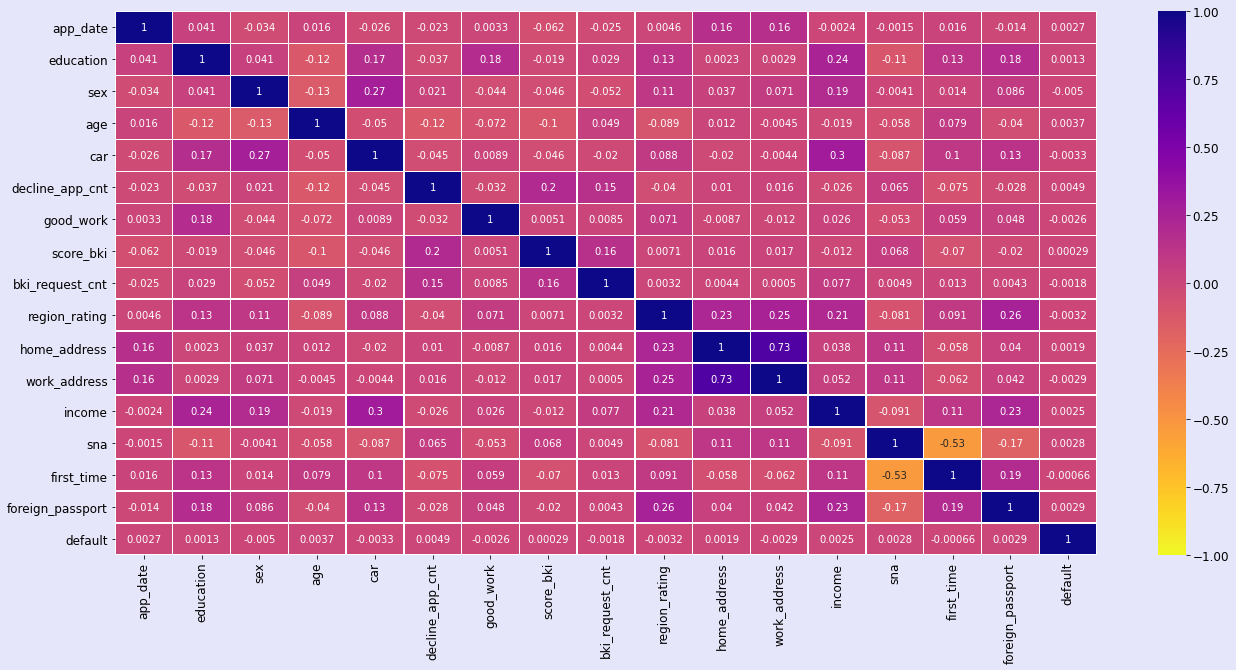

In [19]:
#------------------------------------------------------------------------------#
# Пирсон:
df = data.copy()
df.drop(columns=['client_id', 'flag'], inplace=True)
annot_kws = {'fontsize': 10}
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot = True, cmap= 'plasma_r',
            linewidths=.5, annot_kws=annot_kws)
plt.gcf().set_size_inches(22, 10);

Итак, наблюдаем лишь две пары более-менее значимой корреляции - это признаки `home_address`, `work_address` с коэффициентом корреляции 0.73 и `sna`, `first_time` с коэффициентом корреляции -0.53.

Проверим по Спирмену.

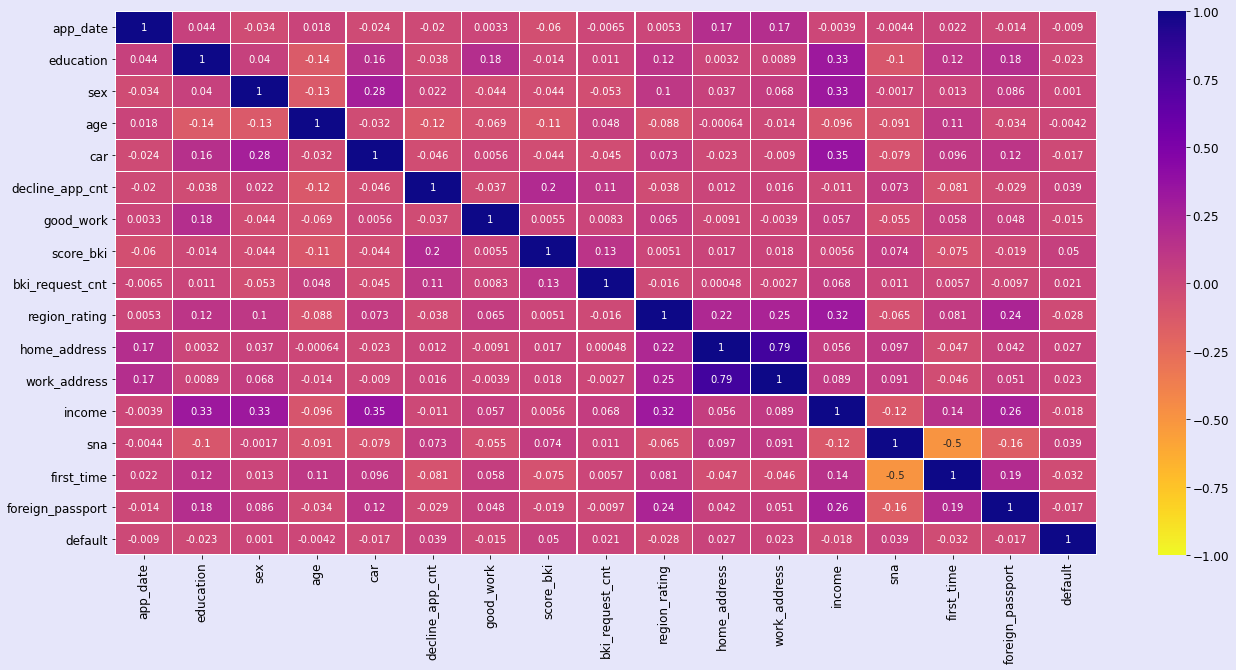

In [20]:
#------------------------------------------------------------------------------#
# Спирмен:
annot_kws = {'fontsize': 10}
sns.heatmap(df.corr(method='spearman'), vmin=-1, vmax=1, annot = True,
            cmap= 'plasma_r', linewidths=.5, annot_kws=annot_kws)
plt.gcf().set_size_inches(22, 10);

Да, две пары признаков коррелируют между собой. Учтём это на будущее.
***

#### 2.6. Базовая (наивная) модель классификации.
В качестве оной возьмём две модели:
* логистическая регрессия
* случайный лес решающих деревьев

Имеем дело с задачей бинарной классификации. **Положительным** классом считается дефолт по взятому кредиту (**default = 1**) - "плохой" клиент, **отрицательным** классом является отсутствие дефолта (**default = 0**) - "хороший" клиент.

In [21]:
#------------------------------------------------------------------------------#
df = data[data.flag=='train'].copy() # Выделяем данные с известными классами.
y = df.default
X = df.drop(columns=['client_id', 'flag', 'default'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                    random_state=SEED, stratify=df.default)
print(X_train.shape, X_test.shape)
# Логистическая регрессия:
lr = LogisticRegression(penalty='none', random_state=SEED, max_iter=1000)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
y_pred_proba = lr.predict_proba(X_test)
# Случайный лес:
rfc = RandomForestClassifier(random_state=SEED)
rfc.fit(X_train, y_train)
y_pred_rfc = rfc.predict(X_test)
y_predict_proba_rfc = rfc.predict_proba(X_test)
# Запоминаем параметры для сравнения:
conf_table_lr = (lr, X_test, y_test, y_pred)
coef_lr = (lr.coef_[0], X.columns)
conf_table_rfc = (rfc, X_test, y_test, y_pred_rfc)
feat_rfc = (rfc.feature_importances_, X.columns)

(59039, 16) (14760, 16)


              precision    recall  f1-score   support

   Не-дефолт      0.873     1.000     0.932     12886
      Дефолт      0.000     0.000     0.000      1874

    accuracy                          0.873     14760
   macro avg      0.437     0.500     0.466     14760
weighted avg      0.762     0.873     0.814     14760



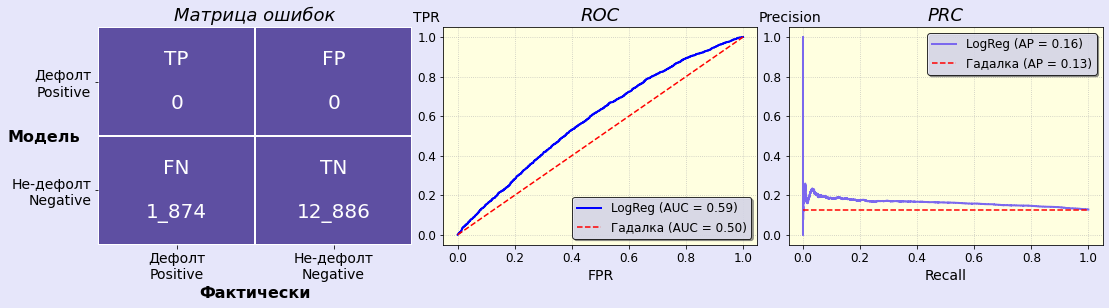

In [22]:
#------------------------------------------------------------------------------#
# Матрица ошибок и ROC:
confusion_table_ROC_and_PRC(*conf_table_lr)
# Отчёт по метрикам:
cl_names = ['Не-дефолт', 'Дефолт']
print(classification_report(conf_table_lr[2], conf_table_lr[3],
                            target_names=cl_names, digits=3))

Итак, мы построили базовую модель логистической регрессии с минимально необходимыми затратами в части обработки данных. Обучение и предсказание показывают, что модель проявляет сильнейшую склонность к объектам наиболее популярного класса, т.е. модель очень плохо предсказывает вероятность дефолта. Этакая добрая-предобрая моделька, которая щедро раздаёт кредиты кому попало. Щедрый банкир, в общем. Вы о таком слышали? Я - нет.

Метрика AUC = 0.59. Не так уж и много, да и смысл в одной только метрике AUC невелик, учитывая вышесказанное. Самое время приступить к улучшению модели.
***

Взглянем на весовые коэффициенты текущей модели логистической регрессии и оценим значимость признаков на основе величин этих коэффициентов.

[-0.00031785]


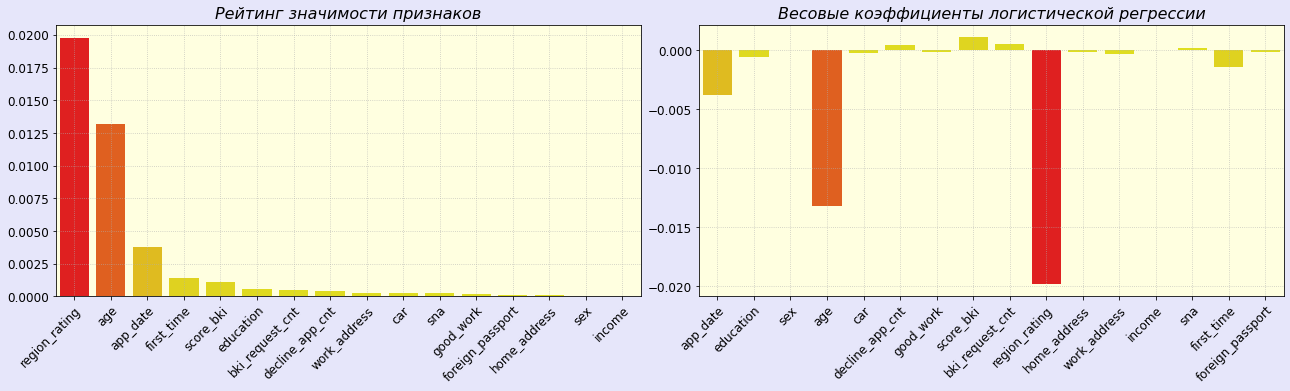

In [23]:
#------------------------------------------------------------------------------#
feature_importance_on_log_reg_coef(*coef_lr)
print(lr.intercept_)

Сравним базовую модель линейной регрессии с базовой моделью случайного леса.

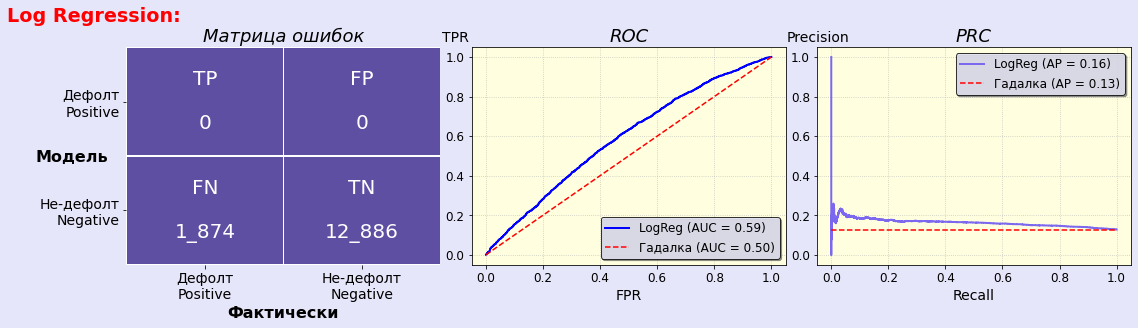

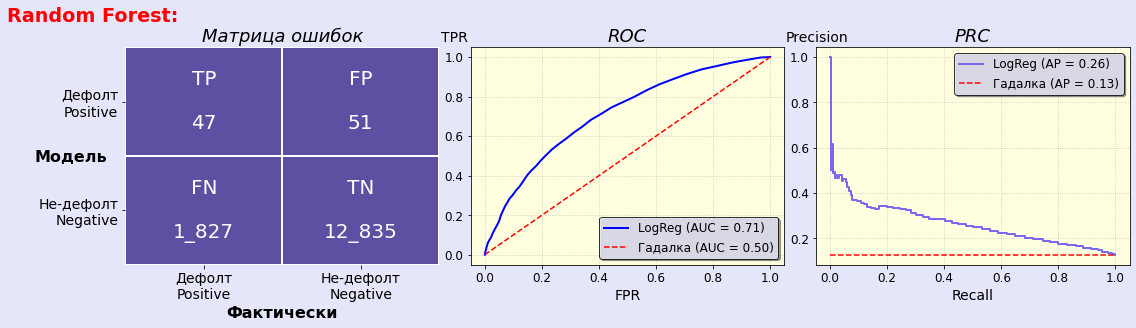

In [24]:
#------------------------------------------------------------------------------#
# Логистическая регрессия:
confusion_table_ROC_and_PRC(*conf_table_lr)
plt.gcf().suptitle('Log Regression:', x=0.1, y=1.02, weight='bold', color='red')
# Случайный лес:
confusion_table_ROC_and_PRC(*conf_table_rfc)
plt.gcf().suptitle('Random Forest:', x=0.1, y=1.02, weight='bold', color='red');

In [25]:
#------------------------------------------------------------------------------#
cl_names = ['Не-дефолт', 'Дефолт']
# Логистическая регрессия:
print('LOG REGRESSION:')
print(classification_report(conf_table_lr[2], conf_table_lr[3],
                            target_names=cl_names, digits=3))
# Случайный лес:
print('='*53, '\nRANDOM FOREST:')
print(classification_report(conf_table_rfc[2], conf_table_rfc[3],
                            target_names=cl_names, digits=3))

LOG REGRESSION:
              precision    recall  f1-score   support

   Не-дефолт      0.873     1.000     0.932     12886
      Дефолт      0.000     0.000     0.000      1874

    accuracy                          0.873     14760
   macro avg      0.437     0.500     0.466     14760
weighted avg      0.762     0.873     0.814     14760

RANDOM FOREST:
              precision    recall  f1-score   support

   Не-дефолт      0.875     0.996     0.932     12886
      Дефолт      0.480     0.025     0.048      1874

    accuracy                          0.873     14760
   macro avg      0.677     0.511     0.490     14760
weighted avg      0.825     0.873     0.820     14760



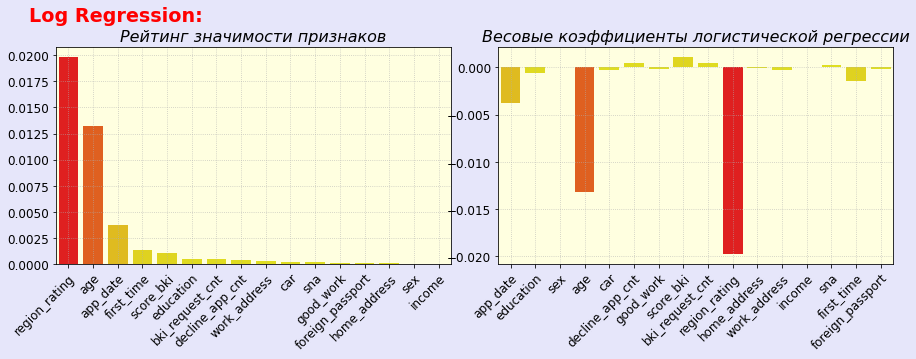

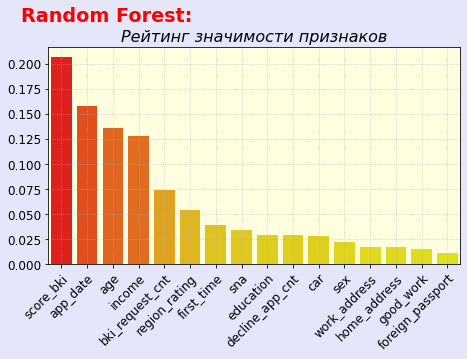

In [26]:
#------------------------------------------------------------------------------#
# Логистическая регрессия:
feature_importance_on_log_reg_coef(*coef_lr)
fig0 = plt.gcf(); fig0.subplots_adjust(wspace=0.12); fig0.set_size_inches(15,4)
fig0.suptitle('Log Regression:', x=0.1, y=1.02, weight='bold', color='red', ha='left')
# Случайный лес:
feature_importance_on_log_reg_coef(*feat_rfc)
fig1 = plt.gcf(); fig1.set_size_inches(15.5,4)
fig1.suptitle('Random Forest:', x=0.1, y=1.02, weight='bold', color='red', ha='left');
fig1.get_axes()[1].set_visible(False)

Видим, что модели примерно одинаково плохие. Отметим, впрочем, что значимость признаков по коэффициентам логистической регрессии и значимость признаков с точки зрения случайного леса - существенно отличаются составом. 
***
Классификатор типа логистической регрессии вычисляет дистанцию между каждым объектом и разделяющей гиперплоскостью (_линейный_ классификатор строит _плоскость_ в пространстве признаков, т.е. поверхность 1-го порядка), дистанция может быть как положительной (для объекта положительного класса - "Дефолт" в нашем случае), так и отрицательной - для объекта отрицательного класса. Логит-преобразование отображает эту дистанцию - число - в пространство вероятностей (отрезок от 0 до 1). Если $p_i$ - вероятность отнесения _i_-го объекта к положительному классу, то в случае бинарной классификации вероятность $q_i$ отнесения _i_-го объекта к отрицательному классу определяется, очевидно, как $q_i = 1 - p_i$. Таким образом, каждому клиенту классификатор присваивает две вероятности принадлежности клиента к двум классам - это $p_i$ и $q_i$. Если $p_i > 0.5$, то объект классифицируется как принадлежащий к положительному классу. В противном случае объект относится к отрицательному классу.

Построим для текущего нашего классификатора типа линейной регрессии распределение вероятностей в зависимости от дистанции между "точкой" клиента в фазовом пространстве и разделяющей плоскостью. Для извлечения дистанции воспользуемся методом decision_function(X) классификатора, где в качестве X будем использовать X_test, конечно.

Количество клиентов в классе "Дефолт": 0 человек.


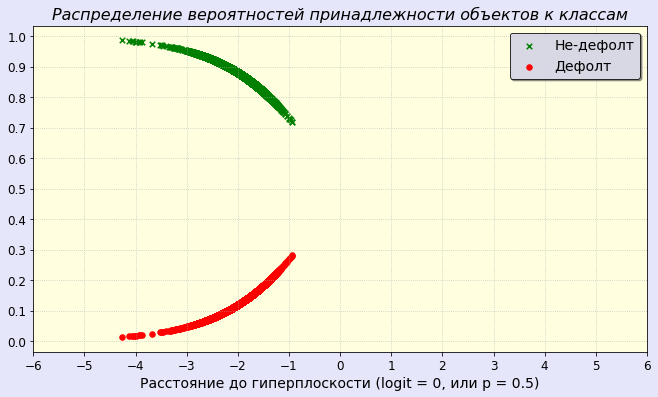

In [27]:
#------------------------------------------------------------------------------#
# Расстояние (дистанция) до разделяющей гиперплоскости:
xx = lr.decision_function(X_test)
# Вычисленные классификатором вероятности принадлежности клиента к классам:
yy = y_pred_proba
#---
fig, ax = plt.subplots(figsize=(11,6))
# Нулевой (отрицательный) класс - "хорошие" клиенты, первый столбец y_prob:
plt.scatter(xx, yy[:,0], s=30, c='green', marker='x', label='Не-дефолт')
# Первый (положительный) класс - "плохие" клиенты, второй столбец y_prob:
plt.scatter(xx, yy[:,1], s=30, c='red', marker='o', label='Дефолт')
#---
ax.legend(fontsize=14);
ax.set_xticks(range(-6,7)); ax.set_yticks(np.arange(0,1.1,.1));
ax.set_xlabel('Расстояние до гиперплоскости (logit = 0, или p = 0.5)')
ax.set_title('Распределение вероятностей принадлежности объектов к классам',
             style='italic');
# Количество клиентов, относящихся к положительному классу "Дефолт":
num_class_1 = yy[yy[:,1]>0.5][:,1].shape[0]
print('Количество клиентов в классе "Дефолт":', num_class_1, 'человек.')

Итак, необходимо улучшить нашу базовую модель классификатора, сделать её "злее".
***

#### 2.7. Улучшение базовой модели.

#### _2.7.1. Баланс классов._
В нашей скоринговой задаче имеет место дисбаланс классов на уровне N : P = 6.9 : 1, где N и P - количество "хороших" ("Не-Дефолт", default = 0) и "плохих" ("Дефолт", default = 1) заёмщиков соответственно. Существуют методы избавления от дисбаланса классов, например:
* undersampling
* oversampling
* class weights

В методах undersampling и oversampling модель в процессе обучения получает обучающую выборку со сбалансированными классами. Применительно к методу undersampling это означает, что мы должны уменьшить количество "хороших" клиентов так, чтобы получить в обучающей выборке баланс классов N = P. Отсюда и название метода - undersampling, т.е. по сути, уменьшение объёма выборки.   
Метод oversampling ("увеличение выборки") поступает наоборот. В этом методе происходит "размножение" объектов более редкого класса. Мне категорически не нравится oversampling потому, что он приводит к набору данных с дубликатами и/или линейно зависимыми строками. Поэтому из двух методов я выберу undersampling.  
Что касается "взвешивания классов" (class weights), этот подход работает на уровне модели, добавляя весовые множители к компонентам log-loss функции по типу (классы 0 и 1)
\begin{equation}
log\;loss = \frac{-1}{N} \sum_{i=1}^N [w_1\,y_i\,ln(p_i) + w_0\,(1-y_i)\,ln(1-p_i)],
\end{equation}
где $y_i$ - метка класса для $i$-го объекта (клиента), $p_i$ - предсказанная моделью вероятность отнесения $i$-го объекта к положительному классу (к классу 1), $w_0$ и $w_1$ - обсуждаемые весовые множители. В scikit-learn для логистической регрессии предусмотрен соответствующий параметр `class_weight`.


##### 2.7.1.1. Баланс классов. Метод class weights для _**немасштабированных**_ признаков.
Применим "взвешивание классов" в лоб - к немасштабированным признакам.

In [28]:
#------------------------------------------------------------------------------#
df = data[data.flag=='train'].copy() # Выделяем данные с известными классами.

y = df.default
X = df.drop(columns=['client_id', 'flag', 'default'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                    stratify=y, random_state=SEED)
print(X_train.shape, X_test.shape)
# Логистическая регрессия:
lr = LogisticRegression(penalty='none', random_state=SEED, max_iter=1000,
                        class_weight='balanced') # Дисбаланс классов
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
y_pred_proba = lr.predict_proba(X_test)
# Случайный лес (дисбаланс классов):
rfc = RandomForestClassifier(random_state=SEED, class_weight='balanced')
rfc.fit(X_train, y_train)
y_pred_rfc = rfc.predict(X_test)
y_predict_proba_rfc = rfc.predict_proba(X_test)
# Запоминаем параметры для сравнения:
conf_table_lr_post = (lr, X_test, y_test, y_pred)
coef_lr_post = (lr.coef_[0], X.columns)
conf_table_rfc_post = (rfc, X_test, y_test, y_pred_rfc)
feat_rfc_post = (rfc.feature_importances_, X.columns)

(59039, 16) (14760, 16)


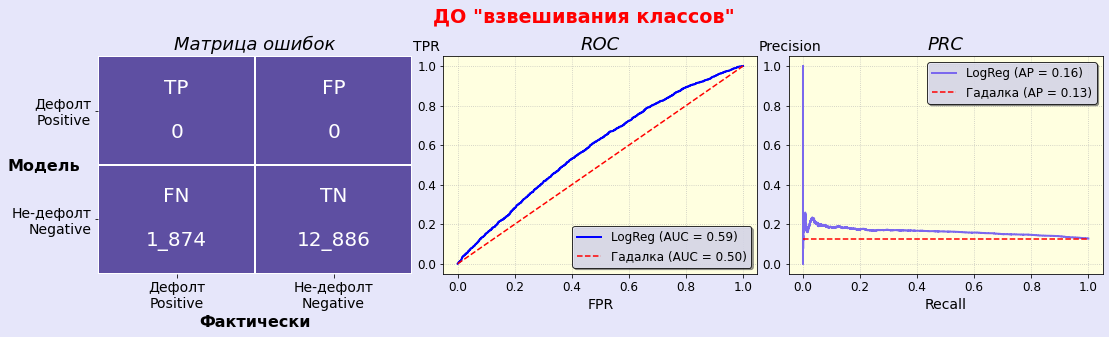

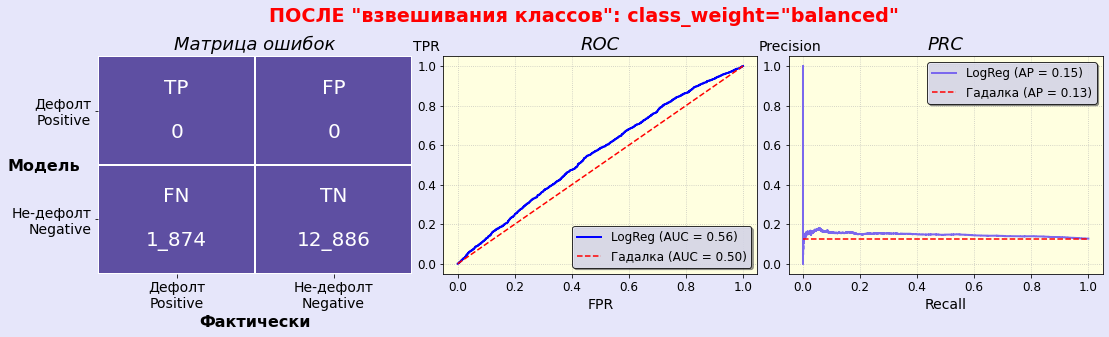

In [29]:
#------------------------------------------------------------------------------#
# Логистическая регрессия. ДО "взвешивания классов":
confusion_table_ROC_and_PRC(*conf_table_lr)
plt.gcf().suptitle('ДО "взвешивания классов"',
                   y=1.05, weight='bold', color='red')
# Логистическая регрессия. ПОСЛЕ "взвешивания классов":
confusion_table_ROC_and_PRC(*conf_table_lr_post)
plt.gcf().suptitle('ПОСЛЕ "взвешивания классов": class_weight="balanced"',
                   y=1.05, weight='bold', color='red');

Как видим, применение class_weight для логистической регрессии не даёт положительного эффекта. Посмотрим, что изменится, если осуществить процедуру масштабирования признаков.

##### 2.7.1.2. Баланс классов. Метод class weights. Масштабирование признаков.
Осуществим "обычную" процедуру масштабирования признаков. Категориальные признаки подвергнем нормализации типа MinMax, а числовые признаки - логарифмированию (где это имеет смысл) и стандартизации типа StandartScaler (или RobustScaler).

Разделение данных на обучающую и тестовую выборки осуществим с использованием параметра `stratify`, который стремится сохранить примерно одинаковый дисбаланс классов как в обучающей, так и тестовой выборках.

In [30]:
#------------------------------------------------------------------------------#
df = data[data.flag=='train'].copy()
df_train, df_test = train_test_split(df, test_size=0.2, random_state=SEED,
                                                        stratify=df.default)
df_ = pd.DataFrame

In [31]:
# Категориальные признаки:
cat_feats = ['education', 'sex', 'car', 'good_work', 'region_rating',
             'home_address', 'work_address', 'sna', 'first_time',
             'foreign_passport']
scaler = MinMaxScaler()
df_train[cat_feats] = df_(scaler.fit_transform(df_train[cat_feats]),
                          columns=cat_feats, index=df_train.index)
df_test[cat_feats] = df_(scaler.transform(df_test[cat_feats]),
                          columns=cat_feats, index=df_test.index)
#------------------------------------------------------------------------------#
# Выборочная проверка:
ddf = df_train.append(df_test)
col = 'region_rating'
print('До:')
display(df[col].value_counts().sort_index())
print('После:')
ddf[col].value_counts().sort_index()

До:


20      206
30      300
40    12027
50    27523
60    16075
70     6199
80    11469
Name: region_rating, dtype: int64

После:


0.000000      206
0.166667      300
0.333333    12027
0.500000    27523
0.666667    16075
0.833333     6199
1.000000    11469
Name: region_rating, dtype: int64

In [32]:
#------------------------------------------------------------------------------#
# Числовые признаки:
num_feats = ['app_date', 'age', 'decline_app_cnt', 'score_bki',
             'bki_request_cnt', 'income']


Признак `app_date`. Временной ряд. Можно проанализировать его поглубже, там есть любопытный тренд, но сейчас просто применим MinMax нормализацию.

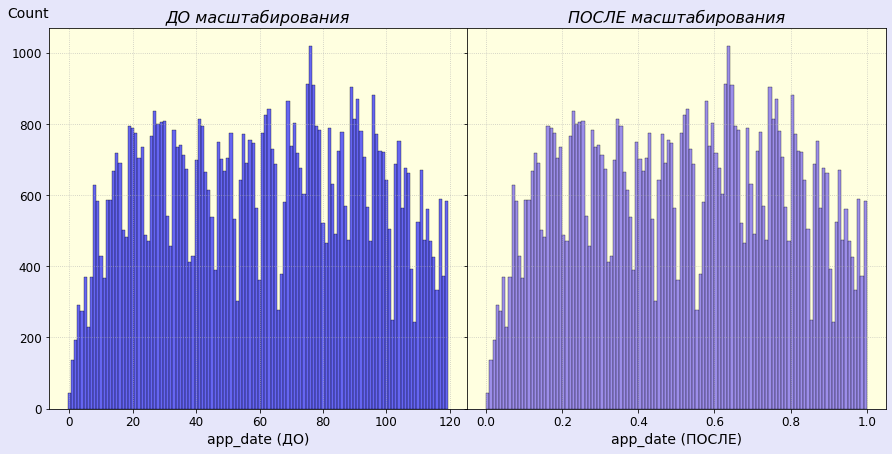

In [33]:
#------------------------------------------------------------------------------#
col = 'app_date'
scaler = MinMaxScaler()
df_train[col] = df_(scaler.fit_transform(df_train[col].values.reshape(-1,1)),
                          columns=[col], index=df_train.index)
df_test[col] = df_(scaler.transform(df_test[col].values.reshape(-1,1)),
                          columns=[col], index=df_test.index)
#---
ddf = df_train.append(df_test)
fig, ax = plt.subplots(1, 2, figsize=(15, 7), sharey=True)
fig.subplots_adjust(wspace=0.)
sns.histplot(data=df, x=col, discrete=True, ax=ax[0], color='blue', alpha=0.6)
sns.histplot(data=ddf, x=col, bins=120, ax=ax[1], color='MediumSlateBlue')
ax[0].set_xlabel('app_date (ДО)'); ax[1].set_xlabel('app_date (ПОСЛЕ)')
ax[0].set_ylabel('Count', rotation=0, position=(0., 1.02), ha='left');
ax[0].set_title('ДО масштабирования', fontstyle='italic')
ax[1].set_title('ПОСЛЕ масштабирования', fontstyle='italic');

Признак `age`. Как мы видели в Разделе 1, признак `age` имеет скошенное влево распределение с модой 31 год. Стандартизируем с помощью RobustScaler.

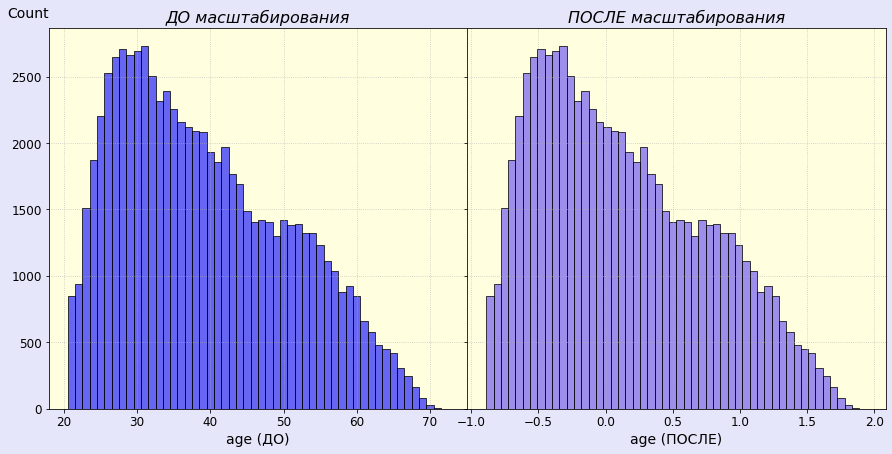

In [34]:
#------------------------------------------------------------------------------#
col = 'age'
rscaler = RobustScaler()
df_train[col] = df_(rscaler.fit_transform(df_train[col].values.reshape(-1,1)), 
                    columns=[col], index=df_train.index)
df_test[col] = df_(rscaler.transform(df_test[col].values.reshape(-1,1)), 
                    columns=[col], index=df_test.index)
#---
ddf = df_train.append(df_test)
fig, ax = plt.subplots(1, 2, figsize=(15, 7), sharey=True)
fig.subplots_adjust(wspace=0.)
sns.histplot(data=df, x=col, discrete=True, ax=ax[0], color='blue', alpha=0.6)
sns.histplot(data=ddf, x=col, bins=df[col].nunique(), ax=ax[1],
             color='MediumSlateBlue')
ax[0].set_xlabel(f'{col} (ДО)'); ax[1].set_xlabel(f'{col} (ПОСЛЕ)')
ax[0].set_ylabel('Count', rotation=0, position=(0., 1.02), ha='left')
ax[0].set_title('ДО масштабирования', fontstyle='italic')
ax[1].set_title('ПОСЛЕ масштабирования', fontstyle='italic');

Признак `score_bki`. В Разделе 1 мы видели, что распределение признака близко к нормальному распределению, но распределение "уехало" в отрицательную область. Применим стандартизацию методом StandardScaler.

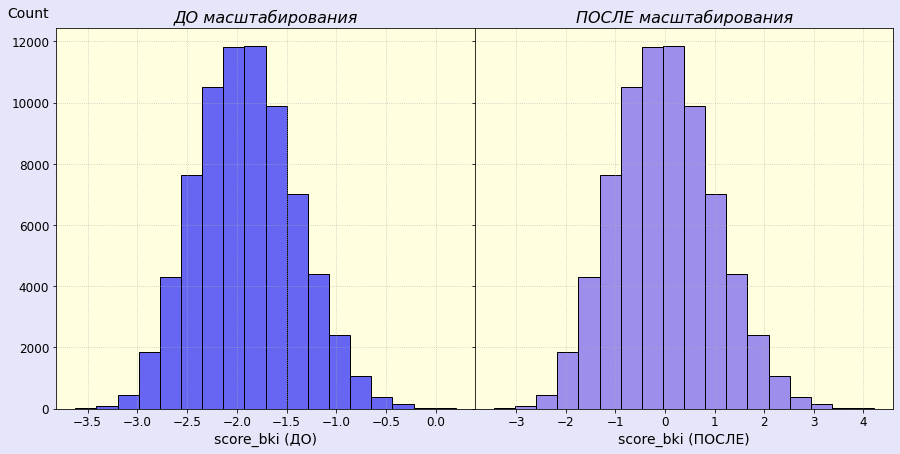

In [35]:
#------------------------------------------------------------------------------#
col = 'score_bki'
scaler = StandardScaler()
df_train[col] = df_(scaler.fit_transform(df_train[col].values.reshape(-1,1)), 
                    columns=[col], index=df_train.index)
df_test[col] = df_(scaler.transform(df_test[col].values.reshape(-1,1)), 
                    columns=[col], index=df_test.index)
#---
ddf = df_train.append(df_test)
fig, ax = plt.subplots(1, 2, figsize=(15, 7), sharey=True)
fig.subplots_adjust(wspace=0.)
sns.histplot(data=df, x=col, bins='sturges', ax=ax[0], color='blue', alpha=0.6)
sns.histplot(data=ddf, x=col, bins='sturges', ax=ax[1], color='MediumSlateBlue')
ax[0].set_xlabel(f'{col} (ДО)'); ax[1].set_xlabel(f'{col} (ПОСЛЕ)')
ax[0].set_ylabel('Count', rotation=0, position=(0., 1.02), ha='left')
ax[0].set_title('ДО масштабирования', fontstyle='italic')
ax[1].set_title('ПОСЛЕ масштабирования', fontstyle='italic');

Признак `income`. Сильно скошенное влево распределение с тяжёлым правым хвостом. Логарифмируем. Стандартизуем методом RobustScaler.

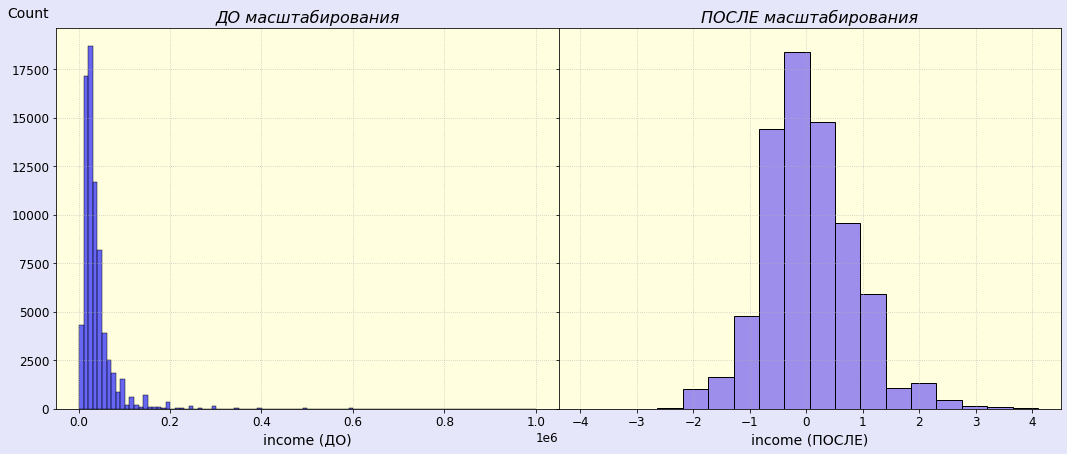

In [36]:
#------------------------------------------------------------------------------#
col = 'income'
df_train[col] = df_train[col].apply(np.log)
df_test[col] = df_test[col].apply(np.log)
scaler = RobustScaler()
df_train[col] = df_(scaler.fit_transform(df_train[col].values.reshape(-1,1)), 
                    columns=[col], index=df_train.index)
df_test[col] = df_(scaler.transform(df_test[col].values.reshape(-1,1)), 
                    columns=[col], index=df_test.index)
#---
ddf = df_train.append(df_test)
fig, ax = plt.subplots(1, 2, figsize=(18, 7), sharey=True)
fig.subplots_adjust(wspace=0.)
sns.histplot(data=df, x=col, bins=100, ax=ax[0], color='blue', alpha=0.6)
sns.histplot(data=ddf, x=col, bins='sturges', ax=ax[1], color='MediumSlateBlue')
ax[0].set_xlabel(f'{col} (ДО)'); ax[1].set_xlabel(f'{col} (ПОСЛЕ)')
ax[0].set_ylabel('Count', rotation=0, position=(0., 1.02), ha='left')
ax[0].set_title('ДО масштабирования', fontstyle='italic')
ax[1].set_title('ПОСЛЕ масштабирования', fontstyle='italic');
ax[1].set_ylabel('');

Признаки `decline_app_cnt` и `bki_request_cnt`. Преобразуем оба этих признака в векторные признаки с помощью get_dummies.

С другой стороны, сильная немонотонность распределения этого признака представляется довольно удобным свойством, если мы хотим преобразовать признак `decline_app_cnt` из числового в категориальный, - получится сравнительно немного категорий. Сделаем это вручную, ориентируясь на df_train и на такое количество категорий, чтобы в последней категории было около 100 клиентов.

In [37]:
#------------------------------------------------------------------------------#
cols = ['decline_app_cnt', 'bki_request_cnt']
df_train = pd.get_dummies(df_train, columns=cols)
df_test = pd.get_dummies(df_test, columns=cols)

##### 2.7.1.3. Баланс классов. Метод class weights. Результаты.
Посмотрим на результаты "взвешивания классов" после масштабирования признаков. Сравним с наивной моделью.

In [38]:
#------------------------------------------------------------------------------#
y_train = df_train.default
X_train = df_train.drop(columns=['client_id', 'flag', 'default'])
y_test = df_test.default
X_test = df_test.drop(columns=['client_id', 'flag', 'default'])
print(X_train.shape, X_test.shape)
# Логистическая регрессия:
lr = LogisticRegression(penalty='none', random_state=SEED, max_iter=1000)

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
y_pred_proba = lr.predict_proba(X_test)
# Запоминаем параметры для сравнения:
conf_table_features_scaled = (lr, X_test, y_test, y_pred)

(59039, 32) (14760, 32)


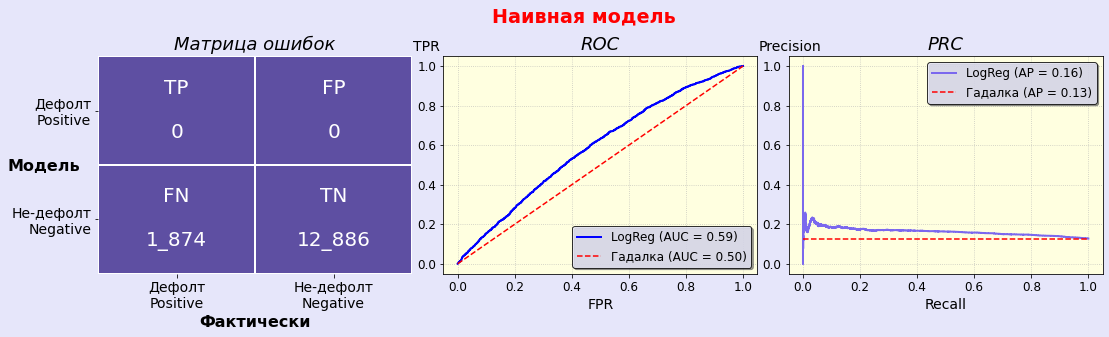

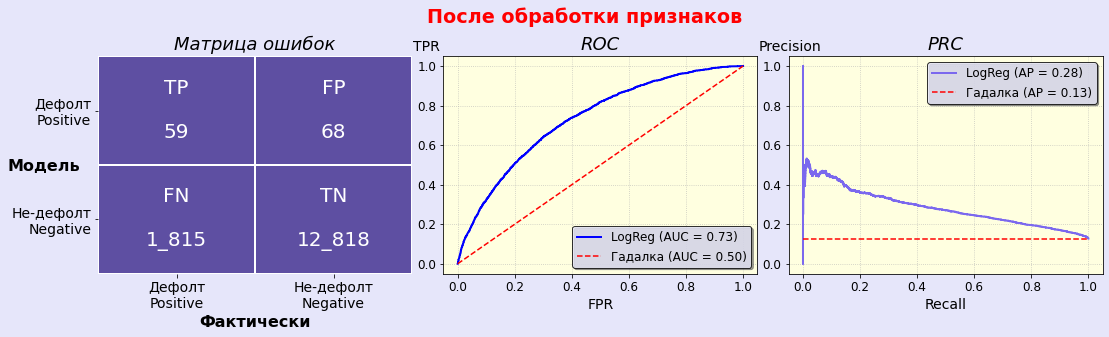

In [39]:
#------------------------------------------------------------------------------#
# Логистическая регрессия. Базовая модель:
confusion_table_ROC_and_PRC(*conf_table_lr)
plt.gcf().suptitle('Наивная модель', y=1.05, weight='bold', color='red')
# Логистическая регрессия. ПОСЛЕ обработки признаков:
confusion_table_ROC_and_PRC(*conf_table_features_scaled)
plt.gcf().suptitle('После обработки признаков', y=1.05,
               weight='bold', color='red');

Обработка признаков сдвигает с мёртвой точки класс "Дефолт" - классификатор соизволил что-то классифицировать как принадлежащее этому классу. Отметим также определённую бесполезность метрики AUC ROC.

Учтём дисбаланс классов с помощью параметра class_weght логистической регрессии.

In [40]:
#------------------------------------------------------------------------------#
y_train = df_train.default
X_train = df_train.drop(columns=['client_id', 'flag', 'default'])
y_test = df_test.default
X_test = df_test.drop(columns=['client_id', 'flag', 'default'])
print(X_train.shape, X_test.shape)
# Логистическая регрессия:
lr = LogisticRegression(penalty='none', random_state=SEED, max_iter=1000,
                        class_weight='balanced') # Баланс классов
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
# Запоминаем параметры для сравнения:
conf_table_class_weight_balanced = (lr, X_test, y_test, y_pred)

(59039, 32) (14760, 32)


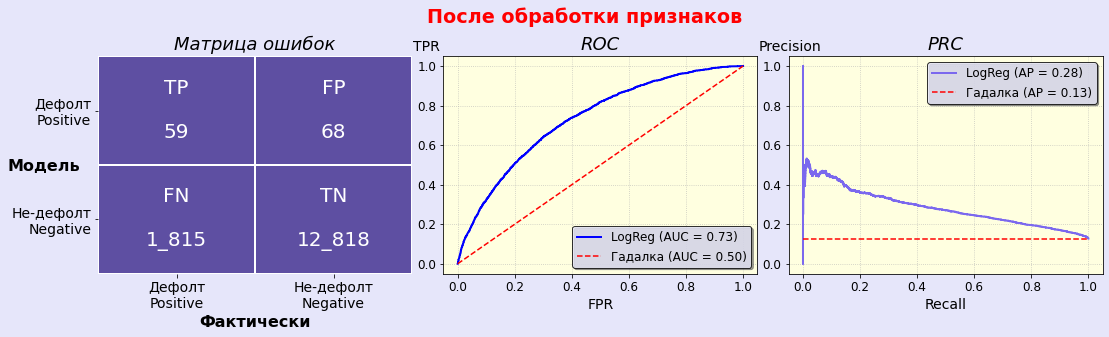

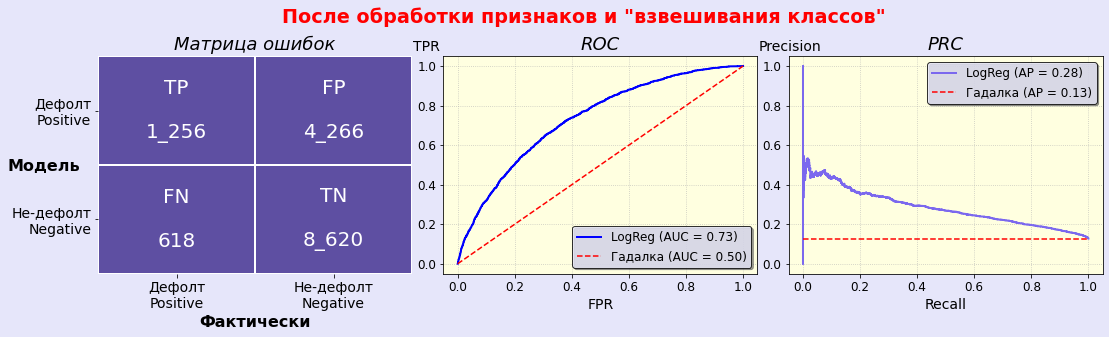

In [41]:
#------------------------------------------------------------------------------#
# Логистическая регрессия. ПОСЛЕ обработки признаков:
confusion_table_ROC_and_PRC(*conf_table_features_scaled)
plt.gcf().suptitle('После обработки признаков', y=1.05, weight='bold',
                   color='red');
# Логистическая регрессия. ПОСЛЕ "взвешивания классов":
confusion_table_ROC_and_PRC(*conf_table_class_weight_balanced)
plt.gcf().suptitle('После обработки признаков и "взвешивания классов"', y=1.05,
               weight='bold', color='red');

In [42]:
#------------------------------------------------------------------------------#
cl_names = ['Не-дефолт', 'Дефолт']
# Логистическая регрессия. После обработки признаков:
print('='*53)
print('ПОСЛЕ обработки признаков:')
print('-'*53)
print(classification_report(
                            conf_table_features_scaled[2],
                            conf_table_features_scaled[3],
                            target_names=cl_names,
                            digits=3)
                            )
# Логистическая регрессия. ПОСЛЕ "взвешивания классов":
print('='*53, '\nПОСЛЕ обработки признаков и взвешивания классов:')
print('-'*53)
print(classification_report(
                            conf_table_class_weight_balanced[2],
                            conf_table_class_weight_balanced[3],
                            target_names=cl_names,
                            digits=3)
                            )
print('='*53)

ПОСЛЕ обработки признаков:
-----------------------------------------------------
              precision    recall  f1-score   support

   Не-дефолт      0.876     0.995     0.932     12886
      Дефолт      0.465     0.031     0.059      1874

    accuracy                          0.872     14760
   macro avg      0.670     0.513     0.495     14760
weighted avg      0.824     0.872     0.821     14760

ПОСЛЕ обработки признаков и взвешивания классов:
-----------------------------------------------------
              precision    recall  f1-score   support

   Не-дефолт      0.933     0.669     0.779     12886
      Дефолт      0.227     0.670     0.340      1874

    accuracy                          0.669     14760
   macro avg      0.580     0.670     0.559     14760
weighted avg      0.844     0.669     0.723     14760



Итак, использование параметра `class_weight='balanced'` и масштабирование признаков привели к существенному улучшению модели. Улучшенная модель имеет плохое разрешение по precision для класса "Дефолт", т.е. среди всех клиентов, которые модель определила как "плохих", лишь меньшая часть из них является истинно-"дефолтной".

Мы положили параметр `class_weight` равным 'balanced', но можно, в принципе, задавать "свои" значения для весов классов в функционале log loss. Чтобы сделать это, я воспользовался [этой статьёй](https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/). Я провёл небольшое исследование, чтобы выяснить, как именно меняются элементы матрицы ошибок и основные метрики классификации, если:
* вес класса 0 ("Не-Дефолт") положить равным 1 (т.е. по умолчанию) и не менять его;
* вес класса 1 ("Дефолт") варьировать в широком диапазоне, начиная с 0.

In [43]:
#------------------------------------------------------------------------------#
weight_class_1 = np.arange(0, 125.5, 0.5)
conf_table_cells = []
mcc = []
for w1 in weight_class_1:
    lr = LogisticRegression(penalty='none', random_state=SEED, max_iter=1000, 
                            class_weight={0: 1, 1: w1})
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    conf_table_cells.append((tn, fp, fn, tp))
    mcc.append(matthews_corrcoef(y_test, y_pred))

,MCC,w1,TN,FP,FN,TP
0,0.000000,0.0,12886,0,1874,0
1,0.012500,0.5,12882,4,1872,2
2,0.094468,1.0,12818,68,1815,59
3,0.158832,1.5,12675,211,1701,173
4,0.182110,2.0,12433,453,1584,290
...,...,...,...,...,...,...
246,0.018471,123.0,48,12838,1,1873
247,0.018471,123.5,48,12838,1,1873
248,0.018471,124.0,48,12838,1,1873
249,0.018208,124.5,47,12839,1,1873


Тестовая выборка:
	"Дефолт":     1874
	"Не-Дефолт": 12886
	В сумме:     14760


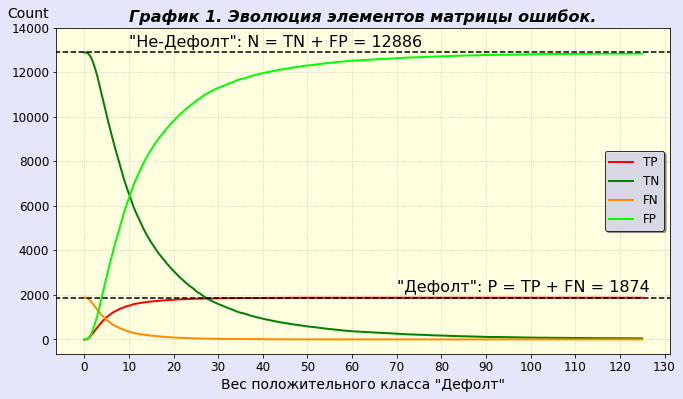

In [44]:
#------------------------------------------------------------------------------#
df_ = pd.DataFrame
df_conf = df_(conf_table_cells, columns=['TN', 'FP', 'FN', 'TP'])
df_conf = df_(weight_class_1, columns=['w1']).join(df_conf)
df_conf = df_(mcc, columns=['MCC']).join(df_conf)
display(df_conf)
# Тестовая выборка. Количество клиентов отрицательного класса "Не-Дефолт":
count_N = y_test[y_test==0].shape[0]
# Тестовая выборка. Количество клиентов положительного класса "Дефолт":
count_P = y_test[y_test==1].shape[0]
print('Тестовая выборка:')
print(f'\t"Дефолт": {count_P:>8d}\n\t"Не-Дефолт": {count_N}')
print(f'\tВ сумме: {count_P + count_N:>9d}')
#---
fig, ax = plt.subplots(figsize=(11, 6))
sns.lineplot(x=df_conf.w1, y=df_conf.TP, linewidth=2, color='red',
             label='TP')
sns.lineplot(x=df_conf.w1, y=df_conf.TN, linewidth=2, color='green',
             label='TN')
sns.lineplot(x=df_conf.w1, y=df_conf.FN, linewidth=2, color='DarkOrange',
             label='FN')
sns.lineplot(x=df_conf.w1, y=df_conf.FP, linewidth=2, color='Lime',
             label='FP');
#---
ax.set_xlim(*ax.get_xlim())
plt.plot([-1e5, 1e5], [count_N, count_N], lw=1.5, ls='--', c='k')
plt.plot([-1e5, 1e5], [count_P, count_P], lw=1.5, ls='--', c='k')
#------------------------------------------------------------------------------#
ax.legend()
ax.set_title('График 1. Эволюция элементов матрицы ошибок.', style='italic',
             fontsize=16, fontweight='bold')
ax.set_xlabel('Вес положительного класса "Дефолт"')
ax.set_xticks(range(0, 140, 10)); ax.set_yticks(range(0, 16000, 2000))
ax.set_ylabel('Count', rotation=0, position=(0,1.02), ha='left')
ax.text(10, count_N * 1.01, f'"Не-Дефолт": N = TN + FP = {count_N}',
        va='bottom');
ax.text(70, count_P + count_N * 0.01, f'"Дефолт": P = TP + FN = {count_P}',
        va='bottom');

##### _Промежуточные выводы._
|    Actual   $\,\,\,\,\Longrightarrow$     |      _Positive_   |    _Negative_     |
|-------------------|-------------------|-------------------|
|  _Positive_ |          TP       |        FP         |
| _Negative_ |          FN       |        TN         |
|    $\Uparrow$  Predicted             |                |                 |

1. Вне зависимости от использования `class_weight`, для матрицы ошибок выполняется очевидное условие:
$$
N = TN + FP = \text{const}_0 \;\;и\;\; P = TP + FN = \text{const}_1, \ \ \ \ (1)
$$
где $N$ и $P$ - количества клиентов отрицательного ("Не-Дефолт") и положительного ("Дефолт") классов соответственно. Для тестовой выборки имеем: N = 12886, P = 1874.
2. В начальный момент, когда вес положительного класса "Дефолт" $w_1 = 0$, классификатор рассматривает все объекты как принадлежащие одному отрицательному классу "Не-Дефолт", что логично: TN = P = 12886, FN = N = 1874.
3. С одной стороны, по мере увеличения веса $w_1$ величина TN уменьшается и стремится к нулю, а FP растёт и выходит на асимптоту N - в соответствии с условием (1). С другой стороны, рост $w_1$ вызывает увеличение TP со стремлением к асимптоте P и уменьшение FN до нуля. Таким образом, при $w_1 \to \infty$ имеем: TP $\to$ P = 1874, FP $\to$ N = 12886.
4. Скорость "перехода" к асимптотам разная у разных классов. Для TP и FN предельные значения устанавливаются сравнительно быстро, а переход для TN и FP происходит гораздо медленнее. Очевидно, что это связано с дисбалансом тестовой выборки: $N : P \approx 7 : 1$.

Образно говоря, увеличение веса класса "Дефолт" - это своеобразный насос, который, с точки зрения классификатора, "перекачивает" объекты из отрицательного класса "Не-Дефолт" в положительный класс "Дефолт". При этом "перекачка" выглядит так: при $w_1 \to \infty$ клиенты из ячейки TN переходят в ячейку FP, а клиенты ячейки FN - в ячейку TP.
***

##### _Посмотрим, как ведут себя основные метрики классификации при изменении веса положительного класса "Дефолт"._
Для отрицательного и положительного классов обозначим через $R_N$ и $R_P$ метрики recall классов, а через $P_N$ и $P_P$ - метрики precision классов. Обозначим также через $F_{\beta}$ соответствующую метрику. Полагая $\beta = 1$, получим метрику $F_1$ как удвоенное среднее гармоническое метрик recall и precision (нет, я не ошибся - это _удвоенное_ среднее гармоническое):

$$
F_{\beta,\,k} = (1 + \beta^2) \frac{P_k\,R_k}{\beta^2\,P_k + R_k}; \ \ \ \ \beta = 1 \to F_{1,\,k} = 2\frac{P_k\,R_k}{P_k + R_k},
$$

где $k = \{N,\,P\}$.    
По определению,

$$
R_P = \frac{TP}{TP + FN} \equiv TPR \equiv Se, \ \ \ \ R_N = \frac{TN}{TN + FP} \equiv 1 - FPR \equiv Sp, \ \ \ \ (2)
$$

$$
P_P = \frac{TP}{TP + FP}, \ \ \ \ P_N = \frac{TN}{TN + FN}, \ \ \ \ (3)
$$

где $Se$ и $Sp$ - чувствительность (Sensitivity) и специфичность (Specificity) соответственно.

##### _Метрика recall._
Метрика recall - полнота охвата классификатором объектов положительного класса "Дефолт" ($R_P$) или объектов отрицательного класса "Не-Дефолт" ($R_N$). Из определения (2) и условия (1) следует, что при увеличении $w_1$ знаменатели $R_P$ и $R_N$ остаются постоянными, т.е. метрики растут пропорционально своему числителю: $R_P \backsim TP, \ \ R_N \backsim TN$. Однако график 1 показывает разную скорость изменения величин $TP$ и $TN$: $TP$ быстрее стремится к 1, нежели $TN$ - к нулю. Отсюда следует, что средняя метрика ("recall_macro") $R_m = (R_P + R_N)\,/\,2$ будет меняться немонотонно по мере увеличения $w_1$, т.е. имеет место экстремум $R_m$. Соответствующее значение $\hat{w_1}$ определяется формально при приравнивании нулю субстанциональной производной от $R_m$:

$$
\frac{D R_m}{d\,w_1} = \frac{\partial R_m}{\partial R_P}\frac{d R_P}{d w_1} + \frac{\partial R_m}{\partial R_N}\frac{d R_N}{d w_1} = 0 \ \ \Longrightarrow \ \ \left(\frac{d R_P}{d w_1}\right)_\hat{w_{1}} - \left|\left(\frac{d R_N}{d w_1}\right)_\hat{w_{1}}\right| = 0,
$$

где учтено, что $d R_N\,/\,d w_1 \le 0$.

Два значения $\hat{w_1}$ можно назвать сразу - это предельные случаи $\hat{w_1} = 0$ и $\hat{w_1} = \infty$, для которых обе производные обращаются в нуль, т.е. имеем тривиальный случай. При этом $R_m = 0.5$ для обоих предельных случаев. Нас же интересует "промежуточный" случай, когда производные не равны нулю и равны по модулю.

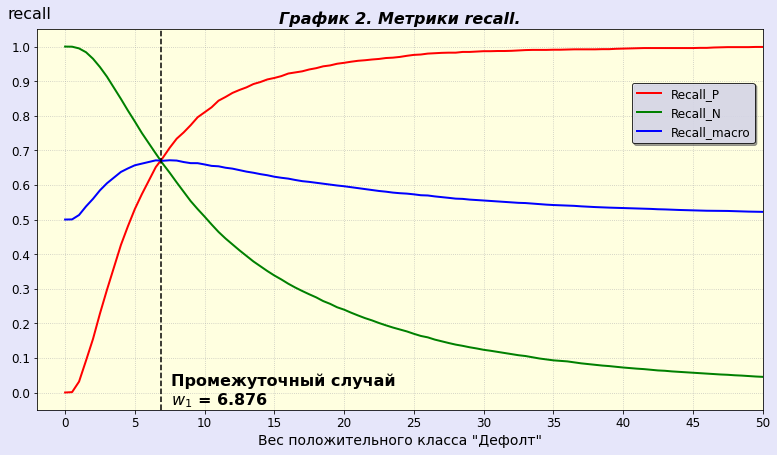

In [45]:
#------------------------------------------------------------------------------#
df_conf['Recall_P'] = df_conf['TP'] / (df_conf['TP'] + df_conf['FN'])
df_conf['Recall_N'] = df_conf['TN'] / (df_conf['TN'] + df_conf['FP'])
df_conf['Recall_macro'] = 0.5 * (df_conf['Recall_P'] + df_conf['Recall_N'])
#---
fig, ax = plt.subplots(figsize=(13, 7))
sns.lineplot(x=df_conf.w1, y=df_conf.Recall_P, linewidth=2, color='red',
             label='Recall_P')
sns.lineplot(x=df_conf.w1, y=df_conf.Recall_N, linewidth=2, color='green',
             label='Recall_N')
sns.lineplot(x=df_conf.w1, y=df_conf.Recall_macro, linewidth=2, color='blue',
             label='Recall_macro');
#---
ax.set_xlim(-2, 50); ax.set_xticks(range(0,55,5));
ax.set_yticks(np.arange(0, 1.1, 0.1)); ax.legend(loc=(0.82,0.7))
ax.set_title('График 2. Метрики recall.', style='italic', fontweight='bold')
ax.set_ylabel('recall', rotation=0, position=(0.,1.02), ha='left', fontsize=16)
ax.set_xlabel('Вес положительного класса "Дефолт"');
# Координаты первой значимой точки пересечения метрик:
w1b = y_test.value_counts()[0] / y_test.value_counts()[1]
w1b = round(w1b, 3)
#---
ax.set_ylim(*ax.get_ylim())
plt.plot([w1b, w1b], [*ax.get_ylim()], lw=1.5, ls='--', c='k')
ax.text(w1b*1.1, ax.get_ylim()[0], f'Промежуточный случай\n$w_1$ = {w1b}',
        c='k', fontweight='bold', va='bottom');

Таким образом, промежуточный случай соответствует `class_weight = 'balanced'`, т.е. $w_0\,:\,w_1 \approx 1\,:\,6.9$. Иначе говоря, $w_1$ для промежуточного случая учитывает дисбаланс классов исходной выборки - так, что это даёт максимум метрики recall_macro.
***

##### _Метрика precision._
Точность классификации - доля клиентов, которых классификатор правильно отнёс к соответствующему классу, среди всех отнесённых к этому классу. Эволюция метрик precision имеет более сложный характер, чем эволюция метрик recall. Рассмотрим два предельных случая: $w_1 = 0$ и $w_1 = \infty$.
1. В случае $w_1 = 0$ получим неопределённостть при вычислении метрики recall для положительного класса "Дефолт": $P_P = TP\,/\,(TP + FP) = 0\,/\,0$. Можно воспользоваться каноническим приёмом и "пролопитировать" эту неопределённость. Судя по графику 1, придётся брать вторые производные, т.к. первые обращаются в нуль. Впрочем, точка $w_1$ практически не имеет смысла, поэтому не будем погружаться.    
Для отрицательного класса получим в качестве $P_N$ долю N на тестовой выборке, т.е. примерно 7/8: $P_N = 12886\,/\,(12886 + 1874) \approx 0.873$.
2. В пределе $w_1 \to \infty$ метрика $P_P$ будет стремиться к доле положительного класса среди всех клиентов, т.е. примерно к величине    
$1/(7 + 1) = 1 / 8 = 0.125,\,\text{или}\,\, P_P = TP\,/\,(TP + FP) \to 1874\,/\,(1874 + 12886) \approx 0.127$.    
А вот $P_N$ повторит судьбу $P_P$ при $w_1 = 0$, т.е. получим неопределённость типа $P_N = 0\,/\,0$. Величина $FN$ стремится к нулю быстрее, в итоге получим $P_N = TN\,/\,(TN + FN) \to TN\,/\,TN \to 1$ при $w_1 \to \infty$.
3. Средняя метрика precision_macro, или $P_m$. В предельном случае $w_1 \to \infty$ эта метрика будет стремиться к величине $P_m = 0.5\,(0.127 + 1) \approx 0.564$. Важно отметить, что, как мы видели ранее, recall_macro стремится в этом случае к 0.5. Следовательно, имеем два, как минимум, пересечения графиков $R_m(w_1)$ и $P_m(w_1)$ - одно пересечение в области сравнительно малых значений $w_1$ и одно пересечение для больших значений $w_1$.

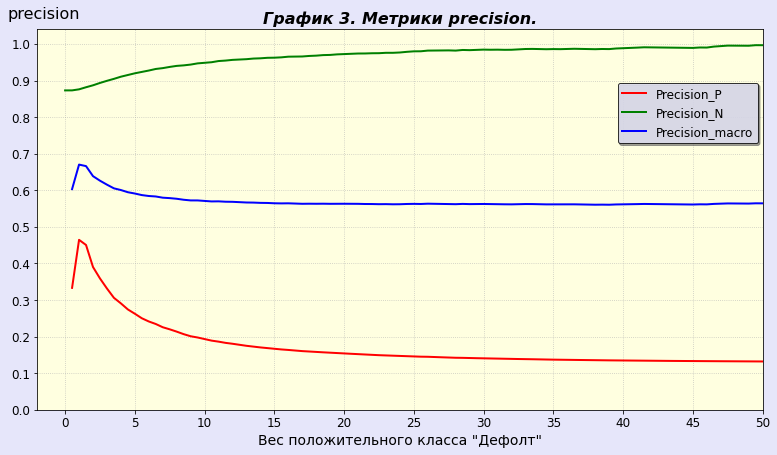

In [46]:
#------------------------------------------------------------------------------#
df_conf['Precision_P'] = df_conf['TP'] / (df_conf['TP'] + df_conf['FP'])
df_conf['Precision_N'] = df_conf['TN'] / (df_conf['TN'] + df_conf['FN'])
df_conf['Precision_macro'] = 0.5 * (
                             df_conf['Precision_P'] + df_conf['Precision_N'])
#---
fig, ax = plt.subplots(figsize=(13, 7))
sns.lineplot(x=df_conf.w1, y=df_conf.Precision_P, linewidth=2, color='red',
             label='Precision_P')
sns.lineplot(x=df_conf.w1, y=df_conf.Precision_N, linewidth=2, color='green',
             label='Precision_N')
sns.lineplot(x=df_conf.w1, y=df_conf.Precision_macro, linewidth=2,
             color='blue', label='Precision_macro');
#---
ax.set_xlim(-2, 50); ax.set_xticks(range(0,55,5));
ax.set_yticks(np.arange(0, 1.1, 0.1)); ax.legend(loc=(0.8,0.7))
ax.set_title('График 3. Метрики precision.', style='italic',
             fontweight='bold')
ax.set_ylabel('precision', rotation=0, position=(0.,1.02), ha='left',
              fontsize=16)
ax.set_xlabel('Вес положительного класса "Дефолт"');

##### _Сравнение эволюции метрик  recall и precision_.

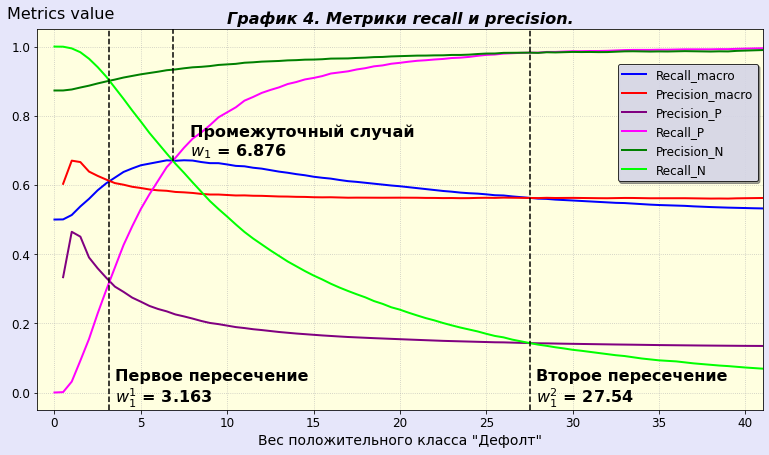

In [47]:
#------------------------------------------------------------------------------#
fig, ax = plt.subplots(figsize=(13, 7))
sns.lineplot(x=df_conf.w1, y=df_conf.Recall_macro, linewidth=2,
             color='blue', label='Recall_macro');
sns.lineplot(x=df_conf.w1, y=df_conf.Precision_macro, linewidth=2,
             color='red', label='Precision_macro');
sns.lineplot(x=df_conf.w1, y=df_conf.Precision_P, linewidth=2,
             color='Purple', label='Precision_P');
sns.lineplot(x=df_conf.w1, y=df_conf.Recall_P, linewidth=2,
             color='Fuchsia', label='Recall_P');
sns.lineplot(x=df_conf.w1, y=df_conf.Precision_N, linewidth=2,
             color='green', label='Precision_N');
sns.lineplot(x=df_conf.w1, y=df_conf.Recall_N, linewidth=2,
             color='lime', label='Recall_N');
#---
ax.set_xticks(range(0, 45, 5)); ax.set_xlim(-1, 41)
ax.legend(loc=(0.8,0.6))
ax.set_title('График 4. Метрики recall и precision.',
             style='italic', fontweight='bold')
ax.set_ylabel('Metrics value', rotation=0, position=(0.,1.02), ha='left',
              fontsize=16)
ax.set_xlabel('Вес положительного класса "Дефолт"');
#------------------------------------------------------------------------------#
w1_1 = 3.163 # Координаты первой значимой точки пересечения метрик.
w1_2 = 27.54 # Координаты второй значимой точки пересечения метрик.
w1_inter = 6.876 # class_weight = 'balanced'.
ax.set_ylim(*ax.get_ylim())
plt.plot([w1_1, w1_1], [*ax.get_ylim()], lw=1.5, ls='--', c='k')
plt.plot([w1_2, w1_2], [*ax.get_ylim()], lw=1.5, ls='--', c='k')
plt.plot([w1_inter, w1_inter], [df_conf.Precision_macro.max(), ax.get_ylim()[1]],
         lw=1.5, ls='--', c='k')
ax.text(w1_1*1.1, ax.get_ylim()[0], f'Первое пересечение\n$w_1^1$ = {w1_1}',
        c='k', fontweight='bold', va='bottom')
ax.text(w1_2 + w1_1*0.1, ax.get_ylim()[0], 
        f'Второе пересечение\n$w_1^2$ = {w1_2}', c='k', fontweight='bold',
        va='bottom');
ax.text(w1_inter + w1_1*0.3, df_conf.Precision_macro.max(),
        f'Промежуточный случай\n$w_1$ = {w1_inter}', c='k', fontweight='bold',
        va='bottom', ha='left');

##### _Характерные точки эволюции метрик._
На графике 4 представлена эволюция средних и классовых метрик recall и precision. Видно, что имеют место два характерных пересечения этих метрик. Мы не приводим здесь уточняющий расчёт координат этих точек пересечения (более мелкая сетка в окрестности пересечений), его результаты дают для веса положительного класса "Дефолт" следующие значения: $w_1^{(1)} = 3.163$ для первого пересечения метрик и $w_1^{(2)} = 27.54$ для второго пересечения.

Свойства предсказаний модели в точках пересечения метрик:
1. **Первое пересечение** $w_1^{(1)} = 3.163$. Для этого случая имеем следующие равенства: $R_N = P_N$, $R_P = P_P$, $R_{macro} = P_{macro}$.
    * Из равенства $R_N = P_N$ имеем: $TN\,/\,(TN + FP) = TN\,/\,(TN + FN) \Longrightarrow FP = FN$, а также $F_{1,\,N} = R_N = P_N$.
    * Аналогично для положительного класса "Дефолт", $R_P = P_P \Longrightarrow FP = FN$ и $F_{1,\,P} = R_P = P_P$.
    * Равенство $R_{macro} = P_{macro}$ позволяет сделать заключение: `f1_macro = precision_macro = recall_macro`.
2. **Второе пересечение** $w_1^{(2)} = 27.54$. Получаем "перекрёстные" равенства вида $R_P = P_N$, $R_N = P_P$ и снова $R_{macro} = P_{macro}$.
    * Из перекрёстных равенств - например, из равенства $R_P = P_N$ - следует: $R_P = P_N \Longrightarrow TP\,/\,(TP + FN) = TN\,/\,(TN + FN)$. Выражая отсюда $FN$, получим $TP = TN$.
    * Из равенства $R_{macro} = P_{macro}$ и перекрёстных равенств следует совпадение среднего и классовых значений метрики $F_1$: $\text{f1_macro} = F_{1,\,P} = F_{1,\,N}$.

Таким образом, с точки зрения матрицы ошибок, первое пересечение приводит к симметричной матрице ($FN = FP$), а второе пересечение - к равенству элементов на главной диагонали ($TP = TN$). Посмотрим, как это выглядит. Добавим "промежуточный" случай, который соответствует `class_weight = 'balanced'`.

##### _Предсказания модели в трёх характерный точках пересечения._

In [48]:
#------------------------------------------------------------------------------#
y_train = df_train.default
X_train = df_train.drop(columns=['client_id', 'flag', 'default'])
y_test = df_test.default
X_test = df_test.drop(columns=['client_id', 'flag', 'default'])
print(X_train.shape, X_test.shape)
# Первое пересечение:
w1_1 = 3.163
# Промежуточный случай (class_weight='balanced'):
w1_inter = y_train.value_counts()[0] / y_train.value_counts()[1]
# Второе пересечение:
w1_2 = 27.54
#---
lr_1 = LogisticRegression(penalty='none', random_state=SEED, max_iter=1000,
                        class_weight={0: 1, 1: w1_1})
lr_inter = LogisticRegression(penalty='none', random_state=SEED, max_iter=1000,
                        class_weight={0: 1, 1: w1_inter})
lr_2 = LogisticRegression(penalty='none', random_state=SEED, max_iter=1000,
                        class_weight={0: 1, 1: w1_2})
lr_1.fit(X_train, y_train)
lr_inter.fit(X_train, y_train)
lr_2.fit(X_train, y_train)
y_pred_1 = lr_1.predict(X_test)
y_pred_inter = lr_inter.predict(X_test)
y_pred_2 = lr_2.predict(X_test)
# Запоминаем параметры для сравнения:
conf_table_1 = (lr_1, X_test, y_test, y_pred_1)
conf_table_inter = (lr_inter, X_test, y_test, y_pred_inter)
conf_table_2 = (lr_2, X_test, y_test, y_pred_2)

(59039, 32) (14760, 32)


##### _Матрицы ошибок, ROC и PRC._

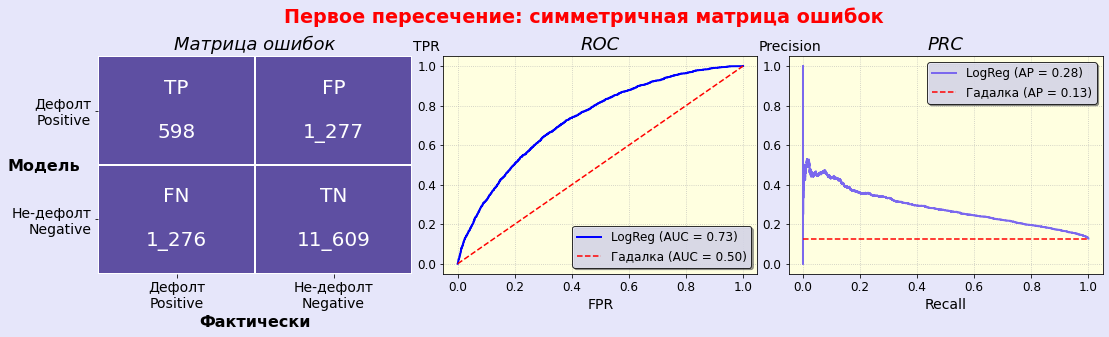

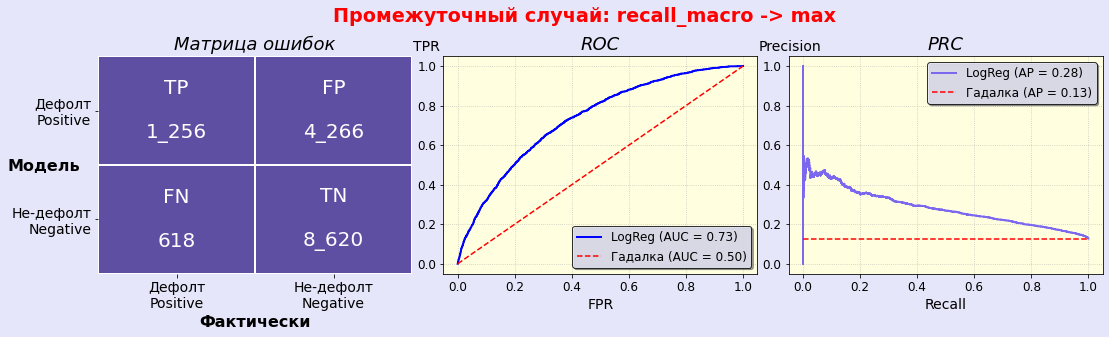

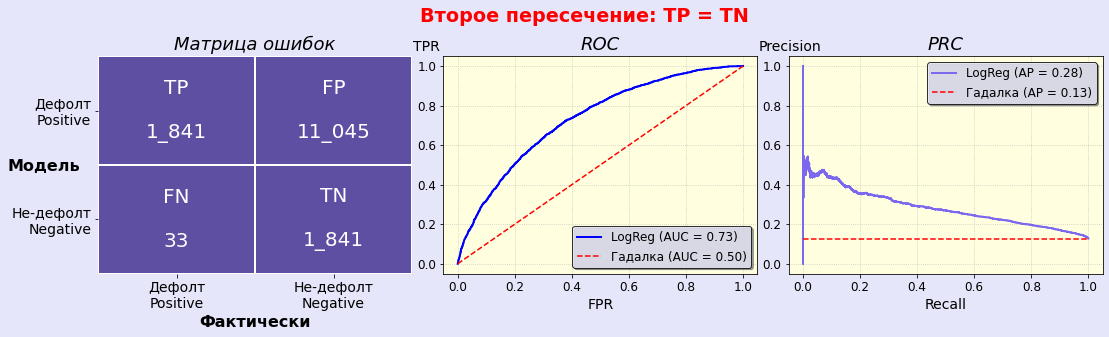

In [49]:
#------------------------------------------------------------------------------#
confusion_table_ROC_and_PRC(*conf_table_1)
plt.gcf().suptitle('Первое пересечение: симметричная матрица ошибок', y=1.05,
                   weight='bold', color='red');
#---
confusion_table_ROC_and_PRC(*conf_table_inter)
plt.gcf().suptitle('Промежуточный случай: recall_macro -> max', y=1.05,
                   weight='bold', color='red');
#---
confusion_table_ROC_and_PRC(*conf_table_2)
plt.gcf().suptitle('Второе пересечение: TP = TN', y=1.05, weight='bold',
                   color='red');

##### _Сравнение классовых метрик._

In [50]:
#------------------------------------------------------------------------------#
cl_names = ['Не-дефолт', 'Дефолт']
clf_rep_1 = classification_report(conf_table_1[2], conf_table_1[3],
                            target_names=cl_names, digits=3)
clf_rep_inter = classification_report(conf_table_inter[2], conf_table_inter[3],
                            target_names=cl_names, digits=3)
clf_rep_2 = classification_report(conf_table_2[2], conf_table_2[3],
                            target_names=cl_names, digits=3)
# Первое пересечение:
print('='*53); print('ПЕРВОЕ пересечение:'); print('-'*53)
print(clf_rep_1[:53]); print(clf_rep_1[55:162])
# Промежуточный случай:
print('='*53); print('ПРОМЕЖУТОЧНОЕ: class_weight="balanced":'); print('-'*53)
print(clf_rep_inter[:53]); print(clf_rep_inter[55:162])
# Второе пересечение:
print('='*53); print('ВТОРОЕ пересечение:'); print('-'*53)
print(clf_rep_2[:53]); print(clf_rep_2[55:162]); print('='*53)

ПЕРВОЕ пересечение:
-----------------------------------------------------
              precision    recall  f1-score   support
   Не-дефолт      0.901     0.901     0.901     12886
      Дефолт      0.319     0.319     0.319      1874
ПРОМЕЖУТОЧНОЕ: class_weight="balanced":
-----------------------------------------------------
              precision    recall  f1-score   support
   Не-дефолт      0.933     0.669     0.779     12886
      Дефолт      0.227     0.670     0.340      1874
ВТОРОЕ пересечение:
-----------------------------------------------------
              precision    recall  f1-score   support
   Не-дефолт      0.982     0.143     0.249     12886
      Дефолт      0.143     0.982     0.249      1874


##### _Сравнение средних метрик._

In [51]:
#------------------------------------------------------------------------------#
# Первое пересечение:
print('='*53); print('ПЕРВОЕ пересечение:'); print('-'*53)
print(clf_rep_1[:53]); print(clf_rep_1[164:-1])
# Промежуточный случай:
print('='*53); print('ПРОМЕЖУТОЧНОЕ: class_weight = "balanced":'); print('-'*53)
print(clf_rep_inter[:53]); print(clf_rep_inter[164:-1])
# Второе пересечение:
print('='*53); print('ВТОРОЕ пересечение:'); print('-'*53)
print(clf_rep_2[:53]); print(clf_rep_2[164:-1]); print('='*53)

ПЕРВОЕ пересечение:
-----------------------------------------------------
              precision    recall  f1-score   support
    accuracy                          0.827     14760
   macro avg      0.610     0.610     0.610     14760
weighted avg      0.827     0.827     0.827     14760
ПРОМЕЖУТОЧНОЕ: class_weight = "balanced":
-----------------------------------------------------
              precision    recall  f1-score   support
    accuracy                          0.669     14760
   macro avg      0.580     0.670     0.559     14760
weighted avg      0.844     0.669     0.723     14760
ВТОРОЕ пересечение:
-----------------------------------------------------
              precision    recall  f1-score   support
    accuracy                          0.249     14760
   macro avg      0.563     0.563     0.249     14760
weighted avg      0.876     0.249     0.249     14760


***
Как указывалось выше, параметр class_weight работает - _с точки зрения классификатора_ - как насос по "перекачке" клиентов из одного класса в другой, а текущая модель классификатора страдает низким показателем метрики precision для положительного класса "Дефолт": precision < 0.5. Можно ли посредством использования одного только параметра class_weight добиться от модели _одновременного_ выполнения двух условий для положительного класса "Дефолт": recall > 0.5 и precision > 0.5 ? Или, что то же, _одновременное_ выполнение условий: TP > FP и TP > FN.    
График внизу (График 5) даёт ясный ответ на этот вопрос. К сожалению, нельзя.

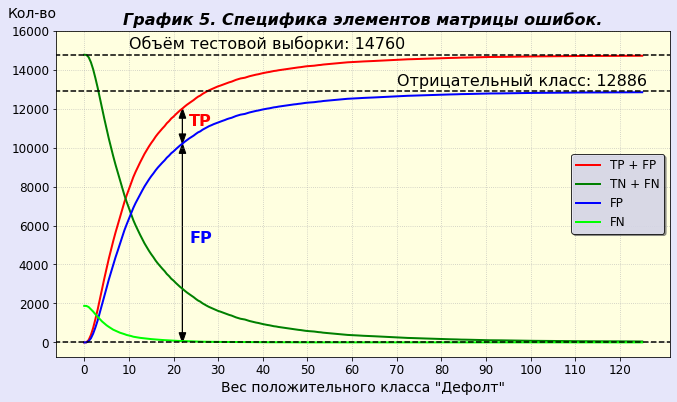

In [52]:
#------------------------------------------------------------------------------#
fig, ax = plt.subplots(figsize=(11, 6))
sns.lineplot(x=df_conf.w1, y=df_conf.TP + df_conf.FP, linewidth=2, color='red',
             label='TP + FP')
sns.lineplot(x=df_conf.w1, y=df_conf.TN + df_conf.FN, linewidth=2, color='green',
             label='TN + FN')
sns.lineplot(x=df_conf.w1, y=df_conf.FP, linewidth=2, color='blue',
             label='FP')
sns.lineplot(x=df_conf.w1, y=df_conf.FN, linewidth=2, color='lime',
             label='FN')
#---
ax.set_xlim(*ax.get_xlim())
plt.plot([-1e5, 1e5], [count_N + count_P, count_N + count_P], lw=1.5, ls='--',
         c='k')
plt.plot([-1e5, 1e5], [0, 0], lw=1.5, ls='--', c='k')
plt.plot([-1e5, 1e5], [count_N, count_N], lw=1.5, ls='--', c='k')
#------------------------------------------------------------------------------#
ax.legend()
ax.set_ylabel('Кол-во', rotation=0, position=(0,1.03), ha='left')
ax.set_xlabel('Вес положительного класса "Дефолт"')
ax.text(10, (count_N + count_P) * 1.01,
        f'Объём тестовой выборки: {count_N + count_P}', va='bottom')
ax.text(70, count_N * 1.01, f'Отрицательный класс: {count_N}', va='bottom')
# Стрелочки!
x1_arr1 = 22; y1_arr1 = 0; y2_arr1 = df_conf[df_conf.w1==x1_arr1].FP.iloc[0]
y1_arr2 = y2_arr1; y2_arr2 = y1_arr2 + df_conf[df_conf.w1==x1_arr1].TP.iloc[0]
ax.arrow(x1_arr1, 0, 0, y2_arr1-500, head_width=1.5, head_length=500, fc='k')
ax.arrow(x1_arr1, y2_arr1, 0, -(y2_arr1-500), head_width=1.5, head_length=500,
         fc='k')
ax.arrow(x1_arr1, y2_arr1, 0, y2_arr2-y1_arr2-500, head_width=1.5,
         head_length=500, fc='k')
ax.arrow(x1_arr1, y2_arr2, 0, -(y2_arr2-y1_arr2-500), head_width=1.5,
         head_length=500, fc='k')
ax.text(x1_arr1*1.07, y2_arr1 + 0.5*(y2_arr2 - y1_arr2), 'TP', c='red',
        fontweight='bold')
ax.text(x1_arr1*1.07, y2_arr1*0.5, 'FP', c='blue', fontweight='bold')
#---
ax.set_title('График 5. Специфика элементов матрицы ошибок.',
             style='italic', fontweight='bold')
#---
ax.set_yticks(range(0, 18_000, 2_000)); ax.set_xticks(range(0, 130, 10));

График 5 показывает, что - увы! - при изменении веса $w_1$ выполняется неравенство $TP \lt FP$ для практически значимого диапазона изменения $w_1$. Отсюда следует, что использование только параметра class_weight не позволяет обеспечить одновременное выполнение условий precision > 0.5 и recall > 0.5 для положительного класса "Дефолт".
***

Для формирования заключительного вывода по использованию параметра class_weight в модели логистической регрессии остаётся лишь определиться с тем, какое именно значение class_weight следует выбрать. Полученную таким образом модель будем считать минимально жизнеспособным продуктом (MVP). Разумеется, выбор должен доставлять экстремум какой-либо метрике или критерию.

Проведённый анализ показал, что наиболее адекватной и информативной "метрикой" является _**сама матрица ошибок**_. Как "доставить экстремум" матрице? Для этого было бы удобно воспользоваться какой-то одной характеристикой матрицы (одним числом) вместо четырёх её элементов TP, TN, FP, FN, т.е. скалярной функцией этих элементов. Вообще, квадратная матрица 2х2 характеризуется набором двух своих "главных" инвариантов: след (trace, tr; или Spur в "старой школе") матрицы (сумма элементов главной диагонали) и определитель (det) матрицы. Для матрицы ошибок имеем:
$$tr = TP + TN,\,\,\,det = TP \cdot TN - FP \cdot FN.$$
Строго говоря, матрица 2х2 является усечённым вариантом тензора 2-го ранга, у которого имеется три инварианта. Однако не будем слишком углубляться, т.к. нам интересен только один инвариант - определитель. Очевидно, что в случае идеального классификатора, когда FP = 0 и FN = 0, определитель матрицы ошибок достигает своего максимального значения. В реальном случае имеем ситуацию, когда FN и FP не обращаются в нуль одновременно. Поскольку мы должны стремиться к идеалу, то, казалось бы, чем большее (при прочих равных) значение примет определитель, тем выше качество классификатора. Таким образом, определитель матрицы ошибок _**можно было бы**_ рассматривать как метрику классификатора, которая "доставляет экстремум" матрице ошибок.

К сожалению, у определителя есть одна неприятная особенность, которая не позволяет использовать его "в лоб" как меру качества классификации. Действительно, равенство $det = TP \cdot TN \ne 0$ может достигаться в трёх случаях:
* $FP = 0, FN \ne 0$
* $FP \ne 0, FN = 0$
* $FP = FN = 0$

Очевидно, что первые два случая далеки от качественной классификации. Например, TP и TN очень малы, но FP (или FN) велико, зато FN (или FP) равно нулю. Понятно, что нас устроит только третий случай, но он явялется лишь частным случаем.

На помощь приходит коэффициент корреляции Мэтьюса, или Matthews correlation coefficient (MCC). По своей сути это - коэффициент корреляции между двумя бинарными случайными величинами, что уже подразумевает его связь с критерием $\chi^2$. Для матрицы ошибок в случае бинарной классификации MCC имеет вид:

$$MCC = \frac{TP \cdot TN - FP \cdot FN}{\sqrt{(TP + FP)(TP + FN)(TN + FP)(TN + FN)}}.$$

В числителе наблюдаем определитель матрицы ошибок. MCC меняется в диапазоне от -1 до +1. Если MCC = 1, тогда (и только тогда) получаем идеальный классификатор с FP = FN = 0. Если же MCC обращается в нуль, имеем случайное угадывание (AU ROC = 0.5), т.е. отсутствие корреляции. Нетрудно убедиться, что для двух указанных выше случаев $FP = 0, FN \ne 0$ или $FP \ne 0, FN = 0$ коэффициент корреляции Мэтьюса будет _**меньше**_ 1.

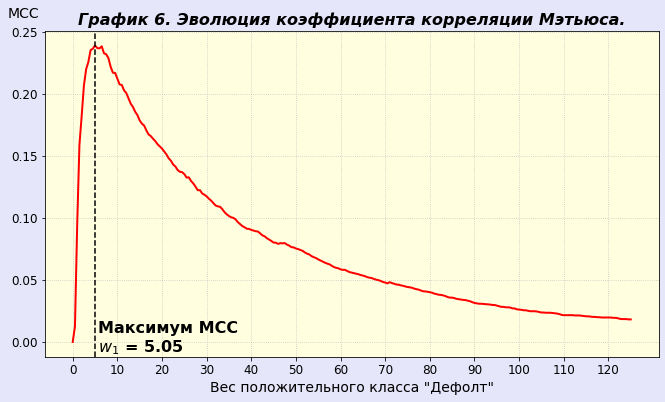

In [53]:
#------------------------------------------------------------------------------#
fig, ax = plt.subplots(figsize=(11, 6))
sns.lineplot(x=df_conf.w1, y=df_conf.MCC, linewidth=2, color='red');
ax.set_ylim(*ax.get_ylim())
w_max_MCC = 5.05
plt.plot([w_max_MCC, w_max_MCC], [*ax.get_ylim()], lw=1.5, ls='--', c='k')
ax.text(w_max_MCC*1.1, ax.get_ylim()[0], f'Максимум MCC\n$w_1$ = {w_max_MCC}',
        c='k', fontweight='bold', va='bottom');
ax.set_xticks(range(0, 130, 10));
ax.set_ylabel('MCC', rotation=0, position=(0,1.03), ha='left')
ax.set_xlabel('Вес положительного класса "Дефолт"');
ax.set_title('График 6. Эволюция коэффициента корреляции Мэтьюса.',
             style='italic', fontweight='bold');

График 6 показывает эволюцию коэффициента корреляции Мэтьюса при изменении веса $w_1$ положительного класса "Дефолт". Расчёт на более тонкой сетке даёт следующий результаты: $w_1 = 5.05, \,\,MCC_{max} = 0.241$. В общем, не слишком большая величина, но хотя бы не равна нулю...

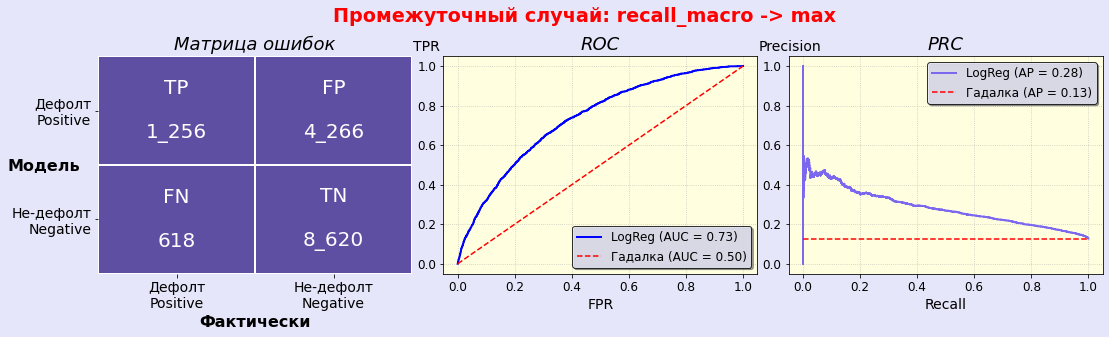

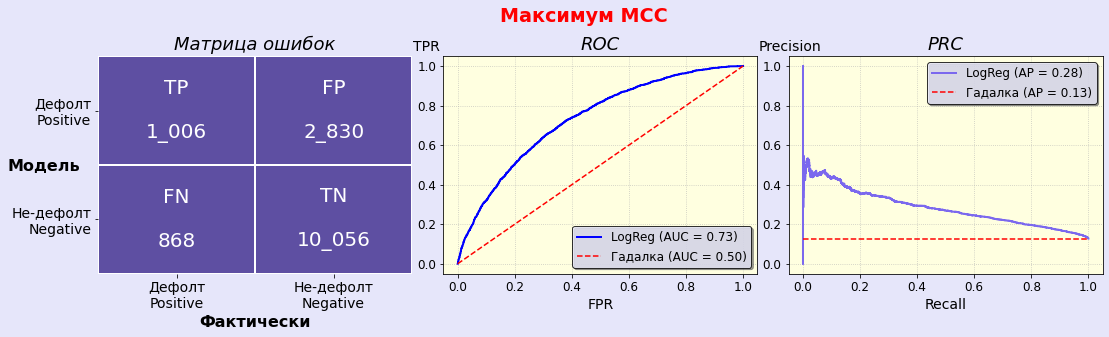

In [54]:
#------------------------------------------------------------------------------#
w1_MCC_max = 5.05
#---
lr_MCC = LogisticRegression(penalty='none', random_state=SEED, max_iter=1000,
                        class_weight={0: 1, 1: w1_MCC_max})
lr_MCC.fit(X_train, y_train)
y_pred = lr_MCC.predict(X_test)
conf_table_MCC = (lr_MCC, X_test, y_test, y_pred)
#---
confusion_table_ROC_and_PRC(*conf_table_inter)
plt.gcf().suptitle('Промежуточный случай: recall_macro -> max', y=1.05,
                   weight='bold', color='red');
confusion_table_ROC_and_PRC(*conf_table_MCC)
plt.gcf().suptitle('Максимум MCC', y=1.05,
                   weight='bold', color='red');

In [55]:
cl_names = ['Не-дефолт', 'Дефолт']
# class_weight = "balanced":
print('='*53,'\nclass_weight = "balanced":')
print('-'*53)
print(classification_report(
                            conf_table_inter[2],
                            conf_table_inter[3],
                            target_names=cl_names,
                            digits=3)[:-1]
                            )
# Максимум MCC:
print('='*53,'\nМаксимум MCC:')
print('-'*53)
print(classification_report(
                            conf_table_MCC[2],
                            conf_table_MCC[3],
                            target_names=cl_names,
                            digits=3)[:-1]
                            )
print('='*53)

class_weight = "balanced":
-----------------------------------------------------
              precision    recall  f1-score   support

   Не-дефолт      0.933     0.669     0.779     12886
      Дефолт      0.227     0.670     0.340      1874

    accuracy                          0.669     14760
   macro avg      0.580     0.670     0.559     14760
weighted avg      0.844     0.669     0.723     14760
Максимум MCC:
-----------------------------------------------------
              precision    recall  f1-score   support

   Не-дефолт      0.921     0.780     0.845     12886
      Дефолт      0.262     0.537     0.352      1874

    accuracy                          0.749     14760
   macro avg      0.591     0.659     0.599     14760
weighted avg      0.837     0.749     0.782     14760


Последний вопрос, который мы разберём в Разделе 2, состоит в следующем. При прочих равных параметрах - существует ли изоморфизм между множеством моделей линейной регрессии с задействованным параметром class_weight и множеством моделей линейной регрессии, обученных на сбалансированной обучающей выборке (oversampling или undersampling) без задействования этого параметра?

##### _**Шутка!**_
***
Просто рассмотрим результаты реализации одного из методов "ресэмплинга" обучающей выборки. При этом модель с class_weight будем называть моделью MVP - минимально жизнеспособный продукт. Более точно, _в качестве MVP примем модель с таким class_weight, который доставляет максимум коэффициенту корреляции Мэтьюса_.

##### 2.7.1.4. Баланс классов. Специальный алгоритм метода undersampling.
Попробуем применить один из методов undersamplig. Обычно подобный метод использует случайный механизм - bootstrap - формирования выборки мажоритарного класса, равной по объёму выборке миноритарного класса. Такой подход означает, что для корректного учёта всех клиентов мажоритарного класса в обучающей выборке необходимо осуществлять bootstrap многие сотни раз, и чем больше обучающая выборка - тем больше нужно сделать итераций обучения модели.

Мы реализуем иной алгоритм метода undersamplig. Его суть состоит в следующем. Разобъём исходную выборку на обучающую и тестовую части. Тестовая выборка священна и неприкосновенна, она сохраняет исходный дисбаланс классов 6.9:1 ("Не-Дефолт" : "Дефолт"). На обучающей выборке выделим класс "Дефолт" в отдельный "фолд", а записи с классом "Не-Дефолт" - в другой фолд. Разобъём фолд "Не-Дефолт" на N "частных" выборок так, чтобы каждая из этих выборок была примерно равна по длине выборке в фолде "Дефолт".  
Далее, объединим "Дефолт" с этой частной выборкой. Иначе говоря, составим выборку, у которой отсутствует дисбаланс классов, т.е. "Дефолт" : "Не_дефолт" = 1 : 1. Перемешаем, обучим модель на этой выборке и запомним эту модель. Затем возьмём следующую частную выборку "Не-Дефолт" и добавим к исходному фолду "Дефолт" (первая частная выборка своё дело сделала и была отодвинута в сторону). Перемешаем, обучим, запомним модель на этой выборке. И так далее.  
После обучения получим N обученных моделей, которые запустим на тестовой выборке. Выберем из них ту, которая доставляет наилучшее значение, например, метрики f1_macro.

In [56]:
#------------------------------------------------------------------------------#
# Из обучающей выборки выделяем "фолд" класса "Дефолт":
df_train_P = df_train[df_train.default==1].copy()
df_train_P = df_train_P.drop(columns=['client_id', 'flag']) # default остался.
# Из обучающей выборки выделяем "фолд" класса "Не-Дефолт":
df_train_N = df_train[df_train.default==0].copy()
df_train_N = df_train_N.drop(columns=['client_id', 'flag']) # default остался.
#---
print('df_train -> n_samples:', df_train.shape[0])
print('train_P -> n_samples:', df_train_P.shape[0])
print('train_N -> n_samples:', df_train_N.shape[0])
print('n_samples_N + n_samples_P =',df_train_N.shape[0]+df_train_P.shape[0])
ratio = df_train_N.shape[0] / df_train_P.shape[0]
print(f'Ratio -> n_samples_N : n_samples_P = {ratio:.1f} : 1')

df_train -> n_samples: 59039
train_P -> n_samples: 7498
train_N -> n_samples: 51541
n_samples_N + n_samples_P = 59039
Ratio -> n_samples_N : n_samples_P = 6.9 : 1


In [57]:
#------------------------------------------------------------------------------#
# Используем класс KFold для разбиения фолда "Не-Дефолт" (без перемешивания)
# на такое количество фолдов, которое обеспечивает примерный баланс классов:
n_folds = int(round(df_train_N.shape[0]/(df_train_P.shape[0]), 0))
print('Количество частных выборок:', n_folds)
print('Примерная длина частной выборки:', int(round(df_train_N.shape[0]/n_folds, 0)))
#---
kf = KFold(n_splits=n_folds)
print(kf)
#------------------------------------------------------------------------------#
models = [] # Для моделей.
for _, idx_arr in kf.split(df_train_N):
# Объединяем фолд "дефолта" с частной выборкой "не-дефолта":
    df_learn = df_train_P.append(df_train_N.iloc[idx_arr])
# Перемешиваем:
    df_learn = shuffle(df_learn)
# Выделяем предикторы и целевой признак:
    y_learn = df_learn.default
    X_learn = df_learn.drop(columns=['default'])
# Обучаем модель на получившейся выборке:
    lr = LogisticRegression(penalty='none', random_state=SEED, max_iter=1000)
    lr.fit(X_learn, y_learn)
# Добавляем обученную модель в список:
    models.append(lr)

Количество частных выборок: 7
Примерная длина частной выборки: 7363
KFold(n_splits=7, random_state=None, shuffle=False)


In [58]:
#------------------------------------------------------------------------------#
# Делаем прогноз каждой модели на тестовой выборке.
# Выбираем ту модель, которая доставляет ...
# ... наилучшее значение интересующей нас метрики:
max_f1_class_1 = -100; max_f1_macro = -100; max_recall_macro = -100;
mcc_max = -100
for model in models:
    y_pred = model.predict(X_test)
    f1_class_1   = f1_score(y_test, y_pred, pos_label=1)
    f1_macro     = f1_score(y_test, y_pred, average='macro')
    recall_macro = recall_score(y_test, y_pred, average='macro')
    mcc_val = matthews_corrcoef(y_test, y_pred)
    if f1_class_1 >= max_f1_class_1: # Модель с лучшей метрикой f1("Дефолт").
        max_f1_class_1 = f1_class_1
        best_f1_model = model
    if f1_macro >= max_f1_macro: # Модель с лучшей метрикой f1_macro.
        max_f1_macro = f1_macro
        best_f1_macro_model = model
    if recall_macro >= max_recall_macro: # Модель с лучшей метрикой recall_macro.
        max_recall_macro = recall_macro
        best_recall_macro_model = model
    if mcc_val >= mcc_max: # Модель с максимальным коэффициентом Мэтьюса.
        mcc_max = mcc_val
        best_mcc_model = model
print('Наилучшие значения метрик:')
print(f'\tf1 "Дефолт": {max_f1_class_1:.3f}')
print(f'\tf1_macro: {max_f1_macro:.3f}')
print(f'\trecall_macro: {max_recall_macro:.3f}')
print(f'\tMCC: {mcc_max:.3f}')
conf_table_balance_f1 = (best_f1_model, X_test, y_test,
                         best_f1_model.predict(X_test))
conf_table_balance_f1_macro = (best_f1_macro_model, X_test, y_test,
                               best_f1_macro_model.predict(X_test))
conf_table_balance_recall_macro = (best_recall_macro_model, X_test, y_test,
                                   best_recall_macro_model.predict(X_test))
conf_table_balance_mcc = (best_mcc_model, X_test, y_test,
                         best_mcc_model.predict(X_test))

Наилучшие значения метрик:
	f1 "Дефолт": 0.339
	f1_macro: 0.558
	recall_macro: 0.671
	MCC: 0.234


##### Лучшая метрика Matthews correlation coefficient . Сравнение с MVP моделью.

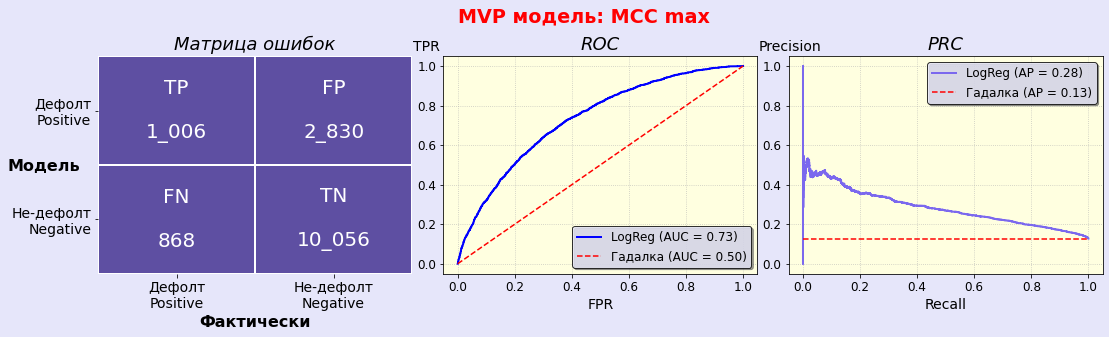

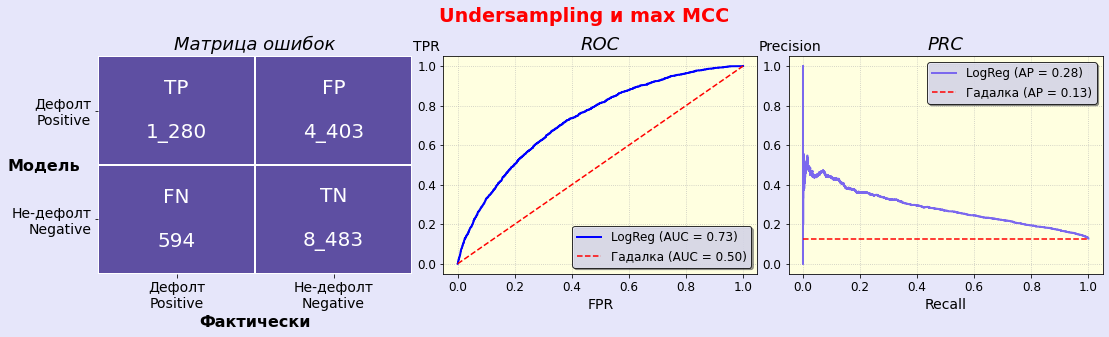

In [59]:
#------------------------------------------------------------------------------#
# MCC max:
confusion_table_ROC_and_PRC(*conf_table_MCC)
plt.gcf().suptitle('MVP модель: MCC max',
                   y=1.05, weight='bold', color='red')
# Логистическая регрессия. Баланс обучения и MCC:
confusion_table_ROC_and_PRC(*conf_table_balance_mcc)
plt.gcf().suptitle('Undersampling и max MCC',
                   y=1.05, weight='bold', color='red');

In [60]:
cl_names = ['Не-дефолт', 'Дефолт']
# MVP модель: MCC max:
print('='*53,'\nMVP модель: MCC max')
print('-'*53)
print(classification_report(
                            conf_table_MCC[2],
                            conf_table_MCC[3],
                            target_names=cl_names,
                            digits=3)[:-1]
                            )
# Обучение на сбалансированной выборке и max MCC:
print('='*53,'\nUndersampling и max MCC:')
print('-'*53)
print(classification_report(
                            conf_table_balance_mcc[2],
                            conf_table_balance_mcc[3],
                            target_names=cl_names,
                            digits=3)[:-1]
                            )
print('='*53)

MVP модель: MCC max
-----------------------------------------------------
              precision    recall  f1-score   support

   Не-дефолт      0.921     0.780     0.845     12886
      Дефолт      0.262     0.537     0.352      1874

    accuracy                          0.749     14760
   macro avg      0.591     0.659     0.599     14760
weighted avg      0.837     0.749     0.782     14760
Undersampling и max MCC:
-----------------------------------------------------
              precision    recall  f1-score   support

   Не-дефолт      0.935     0.658     0.772     12886
      Дефолт      0.225     0.683     0.339      1874

    accuracy                          0.661     14760
   macro avg      0.580     0.671     0.556     14760
weighted avg      0.845     0.661     0.717     14760


In [66]:
dff = df_train.append(df_test)
dff.to_csv('data_MVP.csv', index=False)
dff.sort_index()

,client_id,app_date,education,sex,age,car,good_work,score_bki,region_rating,home_address,...,bki_request_cnt_2,bki_request_cnt_3,bki_request_cnt_4,bki_request_cnt_5,bki_request_cnt_6,bki_request_cnt_7,bki_request_cnt_8,bki_request_cnt_9,bki_request_cnt_10,bki_request_cnt_11
0,25905,0.260504,0.0,1.0,1.388889,1.0,0.0,-0.209437,0.500000,0.0,...,0,0,0,0,0,0,0,0,0,0
1,63161,0.588235,0.0,0.0,1.222222,0.0,0.0,0.747148,0.500000,0.5,...,0,1,0,0,0,0,0,0,0,0
2,25887,0.260504,0.0,1.0,-0.666667,0.5,0.0,0.996362,1.000000,0.0,...,0,0,0,0,0,0,0,0,0,0
3,16222,0.184874,0.0,0.0,0.888889,0.0,0.0,-0.307245,0.500000,0.5,...,1,0,0,0,0,0,0,0,0,0
4,101655,0.899160,0.5,1.0,0.611111,0.0,1.0,1.324446,0.666667,0.5,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73794,54887,0.521008,0.5,0.0,0.444444,0.0,0.0,0.225591,0.500000,0.0,...,0,1,0,0,0,0,0,0,0,0
73795,76821,0.689076,0.0,1.0,0.222222,1.0,0.0,-0.308365,0.500000,0.5,...,0,0,0,0,0,0,0,0,0,0
73796,103695,0.932773,0.0,1.0,-0.333333,0.0,0.0,0.786581,1.000000,0.5,...,0,0,1,0,0,0,0,0,0,0
73797,861,0.025210,0.0,0.0,-0.444444,0.0,1.0,0.853436,0.500000,0.0,...,0,1,0,0,0,0,0,0,0,0


##### 2.7.1.5. Специальный алгоритм метода undersampling. Выводы.
Итак, никаких радикальных улучшений при применении "ресэмплинга" обучающей выборки не наблюдается - по сравнению с MVP моделью. MVP модель является экономичной, т.к. нет необходимости в дополнительных операциях по ресэмплингу. Таким образом, продолжим работать именно с MVP моделью.

### Выводы по Разделу 2.
* Проведена процедура обработки признаков, в результате которой категориальные признаки были преобразованы в числовые признаки ординального типа и нормализованы методом MinMax. Числовые признаки быди подвергнуты логарифмированию (там, где это имело смысл) и стандартизации (StandardScaler, RobustScaler). Числовые признаки `decline_app_cnt` и `bki_request_cnt` были избавлены от редких значений (> процентиль 99%), эти редкие значения оформлены в отдельную группу, и оба признака преобразованы в итоге в "векторный" тип с помощью dummy-трансформации.
* Для учёта дисбаланса классов было исследовано влияние параметра class_weight на предсказания модели логистической регрессии. Показано, что использование встроенного значения 'balanced' (class_weight = 'balanced') действительно учитывает дисбаланс классов и соответствует максимуму средней метрики recall_macro. Модель с class_weight, доставляющим макимум коэффициенту корреляции Мэтьюса, принята в качестве минимально жизнеспособного продукта (MVP).
* Изучение влияния веса положительного класса "Дефолт" $w_1$ позволило выявить характерные "точки пересечения" на эволюционных кривых  для основных (средних и классовых) метрик классификации. Выявленные точки пересечения доставляют максимум тех или иных метрик. Установлено, что параметр class_weight не позволяет достичь диагонального преобладания в матрице ошибок: посредством одного только этого параметра невозможно обеспечить для положительного класса "Дефолт" _**одновременное**_ выполнение условий recall > 0.5 (или TP > FN) и precision > 0.5 (или TP > FP).
* Применён специальный алгоритм метода undersampling. Предсказания модели, обученной на сбалансированных обучающих выборках, показали, что применение "ресэмплинга" обучающей выборки не даёт каких-либо радикальных улучшений по сравнению с MVP моделью.

***
***
### P.S.
Плохо разделимые признаки у нас. Хорошо перемешанная смесь из классов. Линейный классификатор пытается хоть как-то их разделить, но всего лишь строит разделяющую гиперплоскость через некое "средневзвешенное" сечение этого перемешанного облака объектов в пространстве признаков. Что в итоге?

Проиллюстрируем этот итог на примере двух числовых признаков: `app_date` и `score_bki`. Используем логистическую регрессию с параметром class_weight='balanced' и посмотрим на её предсказания при наличии только двух упомянутых признаков (уже обработанных). Графики внизу показывают, что выбранные признаки - это 6-ой (app_date) и 7-ой (score_bki) по значимости, т.е. крепкие середнячки в смысле своего весового вклада среди 15-ти наиболее весомых признаков. Что характерно - два этих признака вносят одинаковый по модулю и противоположный по знаку вклад в логит-функцию: признак app_date снижает логарифм шансов дефолта по кредиту, признак score_bki благоприятствует событию "Дефолт".

In [ ]:
#------------------------------------------------------------------------------#
coef_lr_MCC = (lr_MCC.coef_[0], X_test.columns)
feature_importance_on_log_reg_coef(*coef_lr_MCC, f_count=15)
fig = plt.gcf(); fig.subplots_adjust(wspace=0.12); fig.set_size_inches(15,4);
ax = fig.get_axes()
ax[0].set_title('Первые 15 наиболее значимых признаков', fontstyle='italic');

In [ ]:
#------------------------------------------------------------------------------#
cols = ['app_date', 'score_bki']
y_train = df_train.default
X_train = df_train[cols].copy()
y_test = df_test.default
X_test = df_test[cols].copy()
print(X_train.shape, X_test.shape)
#---
lr = LogisticRegression(penalty='none', random_state=SEED, max_iter=1000,
                        class_weight='balanced')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
# Запоминаем параметры для сравнения:
conf_table_2feat = (lr, X_test, y_test, y_pred)
# Матрица и графики:
confusion_table_ROC_and_PRC(*conf_table_2feat)
plt.gcf().suptitle('MVP модель на признаках "app_date", "score_bki".',
                   y=1.05, weight='bold', color='red');

In [ ]:
def get_line_to_separate(x):
    b0 = lr.intercept_[0]
    b1 = lr.coef_[0][0]
    b2 = lr.coef_[0][1]
    f = - (b0 + b1 * x) / b2
    return f

line_to_separate = df_train.score_bki.apply(get_line_to_separate)

In [ ]:
#------------------------------------------------------------------------------#
reg_rating = np.sort(df_train.region_rating.unique())
sns.jointplot(data=df_train, x='score_bki', y='app_date', hue='default',
              palette=['g', 'r'], space=0.1)
fig = plt.gcf(); fig.set_size_inches(11,8); ax = fig.get_axes()
ax[0].set_yticks(np.arange(0,1.1,.1)); ax[0].set_ylim(-.05,1.05)
plt.axes(ax[0]).plot(df_train.score_bki, line_to_separate, color='b', lw=2,
                     label='separator')
ax[0].legend();

In [ ]:
###%matplotlib
fig = plt.figure(figsize=(11,11))
ax = fig.add_subplot(projection='3d')
x0 = df_test[df_test.default==0].score_bki.values
x1 = df_test[df_test.default==1].score_bki.values
y0 = df_test[df_test.default==0].income.values
y1 = df_test[df_test.default==1].income.values
z0 = df_test[df_test.default==0].age.values
z1 = df_test[df_test.default==1].age.values
#---
ax.scatter(x0, y0, z0, color='green')
ax.scatter(x1, y1, z1, color='red');
xx = np.linspace(-5, 5, 50)
yy = np.linspace(-5, 5, 50)
xx, yy = np.meshgrid(xx, yy)
zz = np.ones((50,50))*0.5
#---
ax.set_xlabel('score_bki')
ax.set_ylabel('income')
ax.set_zlabel('age')
ax.view_init(30, 30);

In [ ]:
1/0

In [ ]:
#------------------------------------------------------------------------------#
col = 'score_bki'
scaler = MinMaxScaler()
df_train[col] = df_(scaler.fit_transform(df_train[col].values.reshape(-1,1)),
                          columns=[col], index=df_train.index)
df_test[col] = df_(scaler.transform(df_test[col].values.reshape(-1,1)),
                          columns=[col], index=df_test.index)
#---
for idx in df_train.index:
    if df_train.loc[idx, 'default'] == 0:
        df_train.loc[idx, 'score_bki'] = df_train.loc[idx, 'score_bki'] - 1
        df_train.loc[idx, 'app_date'] = df_train.loc[idx, 'app_date'] - 1

In [ ]:
#------------------------------------------------------------------------------#
sns.jointplot(data=df_train, x='score_bki', y='app_date', hue='default',
              palette=['g', 'r'], space=0.1)
fig = plt.gcf(); fig.set_size_inches(11,8); ax = fig.get_axes()
#ax[0].set_yticks(np.arange(0,1.1,.1)); ax[0].set_ylim(-.05,1.05)

In [ ]:
###y = dff.default
###X = dff[['score_bki', 'app_date']].copy()
###X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=df.default)
#------------------------------------------------------------------------------#
cols = ['app_date', 'score_bki']
y_train = df_train.default
X_train = df_train[cols].copy()
y_test = df_test.default
X_test = df_test[cols].copy()
lr = LogisticRegression(penalty='none', random_state=SEED, max_iter=1000)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
# Запоминаем параметры для сравнения:
conf_table_2feat = (lr, X_test, y_test, y_pred)
# Матрица и графики:
confusion_table_ROC_and_PRC(*conf_table_2feat)
plt.gcf().suptitle('Гипотетическая модель на признаках "app_date", "score_bki".',
                   y=1.05, weight='bold', color='red');
plt.gcf().get_axes()[2].legend(loc='center right');

In [ ]:
sns.jointplot(data=dff, x='score_bki', y='app_date', hue='default',
              palette=['g', 'r'], space=0.1)
fig = plt.gcf(); fig.set_size_inches(11,8); ax = fig.get_axes()
line_to_separate = dff.score_bki.apply(get_line_to_separate)
plt.axes(ax[0]).plot(dff.score_bki, line_to_separate, color='b', lw=2,
                     label='separator')
ax[0].legend();

In [ ]:
1/0

In [ ]:
#------------------------------------------------------------------------------#
y_train = df_train.default
X_train = df_train.drop(columns=['client_id', 'flag', 'default'])
y_test = df_test.default
X_test = df_test.drop(columns=['client_id', 'flag', 'default'])
print(X_train.shape, X_test.shape)
#---
lr = LogisticRegression(penalty='none', random_state=SEED, max_iter=1000,
                        class_weight='balanced')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
y_pred_proba = lr.predict_proba(X_test)
# Запоминаем параметры для сравнения:
conf_table_balances = (lr, X_test, y_test, y_pred)

confusion_table_ROC_and_PRC(*conf_table_balances)
plt.gcf().suptitle('MVP модель: class_weight = "balanced"',
                   y=1.05, weight='bold', color='red');

In [ ]:
fig, ax = plt.subplots(figsize=(12,5))
sns.histplot(y_pred_proba[:,0], label='Не-Дефолт', color='g')
sns.histplot(y_pred_proba[:,1], label='Дефолт', color='r', alpha=0.5)
#---
ax.legend(); ax.set_xticks(np.arange(0, 1.1, 0.1));
ax.set_xlabel('Вероятность')
#---
ax.set_ylim(*ax.get_ylim())
plt.plot([0.5, 0.5], [*ax.get_ylim()], lw=2, ls='-', c='b')
#---
count_P_plus = sum((y_pred_proba[:,1] >= 0.5))
count_N_plus = sum((y_pred_proba[:,0] >= 0.5))
true_P = (y_test == 1).sum()
true_N = (y_test == 0).sum()
print(f'Количество объектов с y_pred_proba("Дефолт") > 0.5: {count_P_plus}')
print(f'Истинное количество объектов "Дефолт" в тестовой выборке: {true_P}')
print()
print(f'Количество объектов с y_pred_proba("Не-Дефолт") > 0.5: {count_N_plus}')
print(f'Истинное количество объектов "Не-Дефолт" в тестовой выборке: {true_N}')

Разделяющая поверхность - в области наибольшего количества объектов с одинаковыми вероятностями классов P(0) = P(1) = 0.5.